# Set-up MLFlow

In [1]:
!pip install mlflow --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.4/28.4 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 672.8/672.8 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.0 MB/s eta 0:00:00


In [2]:
import mlflow

## Connect storage

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!mkdir mlflow_results

In [4]:
# To use MLFlow on Colab, we need to connect storage. We will use Google Drive

# Define the MLflow storage path in Google Drive
mlflow_storage_path = "/content/drive/My Drive/mlflow_results"

# Set MLflow to log to the Google Drive directory
mlflow.set_tracking_uri(f"file:{mlflow_storage_path}")

In [5]:
# Set up experiment name. Keep the experiment name the same across all models for easy comparison
mlflow.set_experiment("Demand Forecast Guayas")

<Experiment: artifact_location='file:///content/drive/My Drive/mlflow_results/437562355245870403', creation_time=1741439855156, experiment_id='437562355245870403', last_update_time=1741439855156, lifecycle_stage='active', name='Demand Forecast Guayas', tags={}>

## Start MLFlow UI

In [6]:
!pip install pyngrok --quiet

In [146]:
from pyngrok import ngrok, conf
import getpass
import subprocess

In [95]:
subprocess.Popen(["mlflow", "ui", "--backend-store-uri", mlflow_storage_path])

<Popen: returncode: None args: ['mlflow', 'ui', '--backend-store-uri', '/con...>

In [9]:
print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/get-started/your-authtoken")
conf.get_default().auth_token = getpass.getpass()
port=5000
public_url = ngrok.connect(port).public_url
print(f' * ngrok tunnel \"{public_url}\" ')

Enter your authtoken, which can be copied from https://dashboard.ngrok.com/get-started/your-authtoken
··········
 * ngrok tunnel "https://1167-34-75-106-201.ngrok-free.app" 


# Step 1: Load and Explore the Dataset

In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [181]:
import pandas as pd

# Load the dataset
file_path = "/content/final_preprocessed_data.csv"
df = pd.read_csv(file_path, parse_dates=["date"])

# Display the first few rows
df.head()


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,outlier_flag,...,lag_7,lag_30,rolling_std_7,lag_1,lag_2,lag_5,lag_10,lag_12,rolling_mean_7,dcoilwtico
0,16323662,2014-01-01,36,106716,3.0,0.0,GROCERY I,1032,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16324284,2014-01-01,36,1158720,28.0,0.0,GROCERY I,1040,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16352784,2014-01-02,24,106716,2.0,0.0,GROCERY I,1032,0,0,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,95.14
3,16353829,2014-01-02,24,1158720,20.0,0.0,GROCERY I,1040,0,0,...,NaN,NaN,NaN,28.0,NaN,NaN,NaN,NaN,NaN,95.14
4,16355696,2014-01-02,26,106716,8.0,0.0,GROCERY I,1032,0,0,...,NaN,NaN,NaN,2.0,3.0,NaN,NaN,NaN,NaN,95.14


In [182]:
df.columns

Index(['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion',
       'family', 'class', 'perishable', 'outlier_flag', 'holiday_flag',
       'expanding_mean', 'lag_7', 'lag_30', 'rolling_std_7', 'lag_1', 'lag_2',
       'lag_5', 'lag_10', 'lag_12', 'rolling_mean_7', 'dcoilwtico'],
      dtype='object')

In [183]:
#Sort data by stores and give the top stores by unit sold
df.groupby('store_nbr')['unit_sales'].sum().sort_values(ascending=False).head(15)
print(df.groupby('store_nbr')['unit_sales'].sum().sort_values(ascending=False).head(15))



store_nbr
28    8744.086807
34    7990.605468
36    5067.843740
35    4631.000000
30    2449.000000
32    1910.605468
24    1089.000000
27    1077.000000
26     884.000000
51     442.000000
Name: unit_sales, dtype: float64


In [184]:
df.shape

(1640, 22)

In [185]:
#Filter the data only fo store number 28
df=df[df['store_nbr']==28]
df.shape

(170, 22)

# Step 2. Prepare data

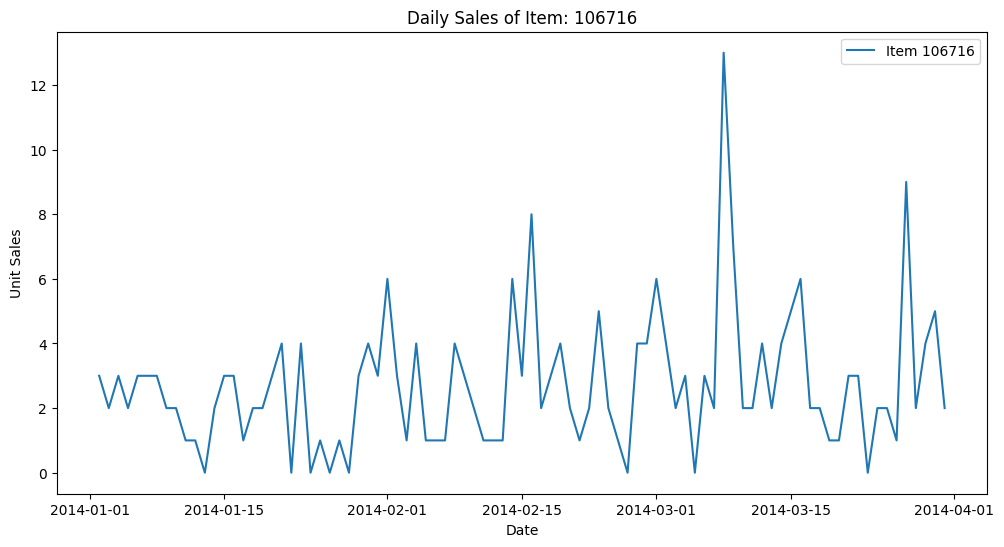

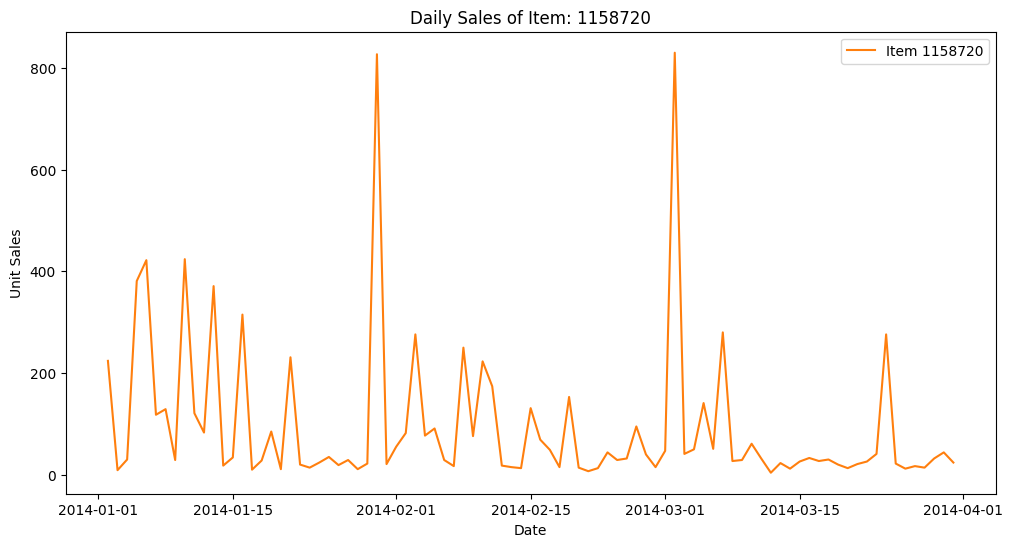

In [186]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Create a copy of the dataframe
df_copy = df.copy()

# Generate a colormap using the recommended method
colormap = plt.colormaps.get_cmap("tab10")  # No need for extra argument

# Iterate through unique item_nbr values
for idx, item_nbr in enumerate(df_copy['item_nbr'].unique()):
    df_item = df_copy[df_copy['item_nbr'] == item_nbr].copy()

    # Group by date and sum unit_sales
    df_item = df_item.groupby('date')['unit_sales'].sum().reset_index()

    # Set 'date' as the index
    df_item.set_index('date', inplace=True)

    # Fill missing dates with zero sales
    df_item = df_item.asfreq('D').fillna(0)

    # Create a plot with a different color for each item
    plt.figure(figsize=(12, 6))
    plt.plot(df_item.index, df_item['unit_sales'], color=colormap(idx % 10), label=f'Item {item_nbr}')

    plt.title(f'Daily Sales of Item: {item_nbr}')
    plt.xlabel('Date')
    plt.ylabel('Unit Sales')
    plt.legend()
    plt.show()


# Step 3. Preprocessing the Data for Prophet

In [187]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# # Normalize the data using Min-Max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df_copy['unit_sales'] = scaler.fit_transform(df_copy[['unit_sales']])

# Initialize dictionaries for different items
X_items = {}
y_items = {}
X_train_items = {}
X_test_items = {}
y_train_items = {}
y_test_items = {}

unique_items = df_copy['item_nbr'].unique()

# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Set sequence length (e.g., past 30 days of sales)
seq_length = 30

# Process each item separately
for item in unique_items:
    item_data = df_copy[df_copy['item_nbr'] == item]

    # Get sequences
    data = item_data['unit_sales'].values
    X, y = create_sequences(data, seq_length)

    # Split into training and testing sets (80% training, 20% testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Reshape for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Store in dictionaries
    X_items[item] = X
    y_items[item] = y
    X_train_items[item] = X_train
    X_test_items[item] = X_test
    y_train_items[item] = y_train
    y_test_items[item] = y_test


# Step 4. Multiplicative Prophet model

In [188]:
!pip install prophet


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt5ojjpic/dj4eud1m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt5ojjpic/6gy9pfb2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21964', 'data', 'file=/tmp/tmpt5ojjpic/dj4eud1m.json', 'init=/tmp/tmpt5ojjpic/6gy9pfb2.json', 'output', 'file=/tmp/tmpt5ojjpic/prophet_model0i6uhx18/prophet_model-20250308201150.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:11:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Run ID: b5ed3a30c481487b9f092797cfee4dd3
Training Prophet model for item: 106716


20:11:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Forecasting completed for item: 106716
✅ 106716 - MAE: 6.67, MSE: 66.01, RMSE: 8.12 (Original Scale)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt5ojjpic/yvnvd1kt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt5ojjpic/69pgzbb3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71600', 'data', 'file=/tmp/tmpt5ojjpic/yvnvd1kt.json', 'init=/tmp/tmpt5ojjpic/69pgzbb3.json', 'output', 'file=/tmp/tmpt5ojjpic/prophet_model4mkaldxa/prophet_model-20250308201155.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:11:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Training Prophet model for item: 1158720


20:11:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Forecasting completed for item: 1158720
✅ 1158720 - MAE: 37.27, MSE: 5662.31, RMSE: 75.25 (Original Scale)
✅ All Prophet models successfully logged to MLflow!


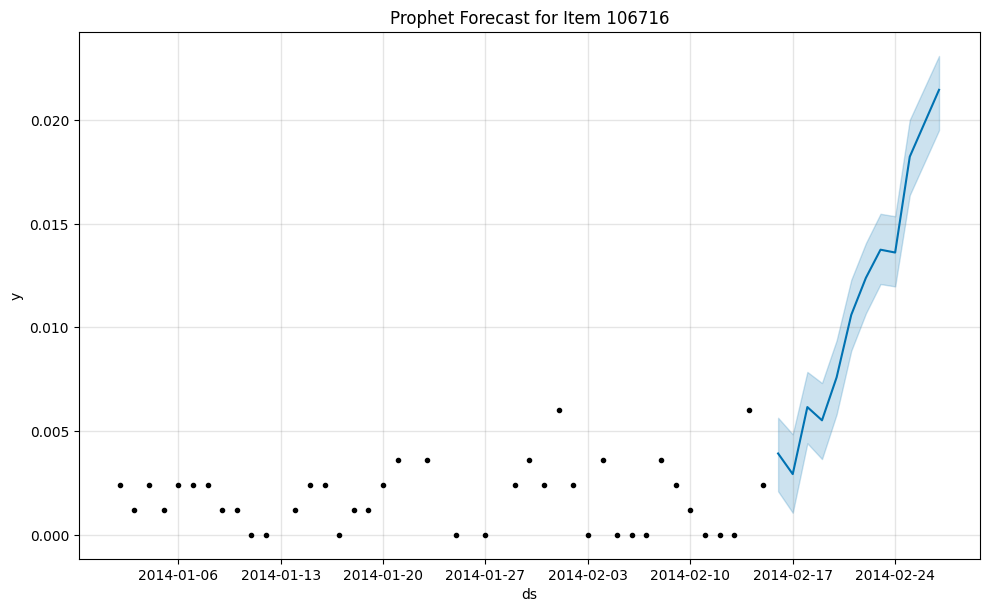

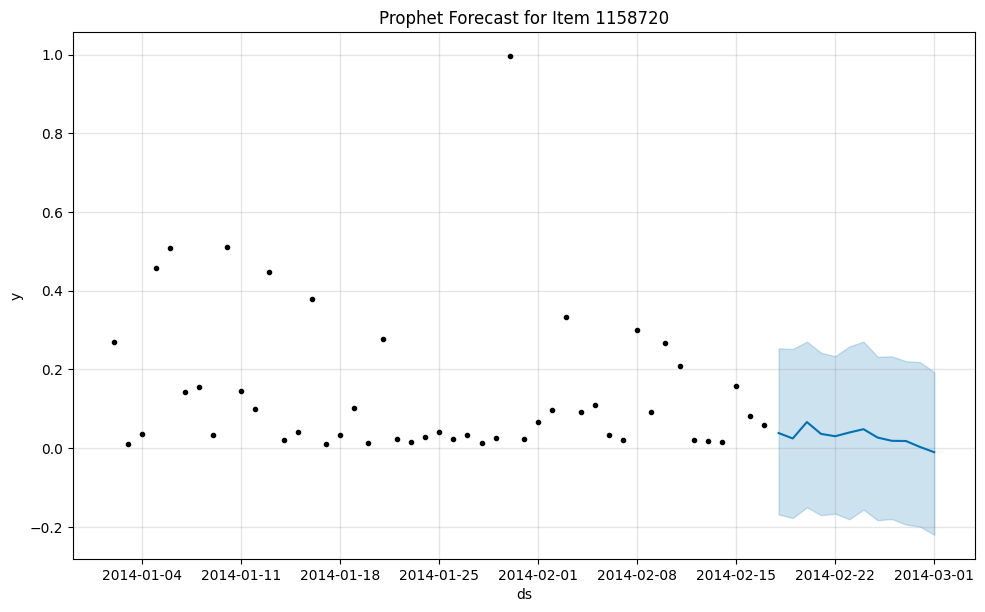

In [189]:
import os
import pickle
import mlflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from tempfile import TemporaryDirectory
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ✅ Start MLflow Run
with mlflow.start_run(run_name="Prophet_Models") as run:
    run_id = run.info.run_id
    print(f"Run ID: {run_id}")

    # Dictionaries to store Prophet models and forecasts
    prophet_models = {}
    forecasts = {}

    # List of external regressors (modify based on your dataset)
    external_regressors = ['promo', 'holiday', 'day_of_week', 'rolling_avg_7', 'rolling_avg_30']

    # ✅ Loop through each unique item (MODEL UNCHANGED)
    for item in unique_items:
        print(f"Training Prophet model for item: {item}")

        # ✅ Extract dataset for the specific item
        item_data = df_copy[df_copy['item_nbr'] == item].copy()
        item_data = item_data.rename(columns={'date': 'ds', 'unit_sales': 'y'})  # Prophet format

        # ✅ Ensure correct alignment between test data and predictions
        train_size = len(y_train_items[item])  # Number of training samples
        test_size = len(y_test_items[item])  # Number of test samples

        # ✅ Extract correct test dates from the dataset
        test_dates = item_data['ds'].iloc[train_size:train_size + test_size].values

        # ✅ Create Prophet model (NO CHANGES)
        model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False,
            seasonality_mode='multiplicative'
        )

        # ✅ Add external regressors
        for reg in external_regressors:
            if reg in item_data.columns:
                model.add_regressor(reg)

        # ✅ Fit the model
        model.fit(item_data.iloc[:train_size])  # Train only on train_data

        # ✅ Create `future` dataframe that exactly matches test set dates
        future = pd.DataFrame({'ds': test_dates})

        # ✅ Add regressors for test period
        for reg in external_regressors:
            if reg in item_data.columns:
                future[reg] = item_data[reg].iloc[train_size:train_size + test_size].values

        # ✅ Generate forecast
        forecast = model.predict(future)

        # ✅ Store trained model & forecast
        prophet_models[item] = model
        forecasts[item] = forecast
        print(f"✅ Forecasting completed for item: {item}")

        # ✅ Reverse MinMax Scaling (Back to Original Scale)
        test_actuals_scaled = np.array(y_test_items[item]).reshape(-1, 1)
        test_predictions_scaled = forecast['yhat'].values.reshape(-1, 1)

        test_actuals_original = scaler.inverse_transform(test_actuals_scaled).flatten()
        test_predictions_original = scaler.inverse_transform(test_predictions_scaled).flatten()

        # ✅ Compute Metrics **on the full test set (original scale)**
        if len(test_actuals_original) == len(test_predictions_original):  # ✅ Ensure proper length match
            mae = mean_absolute_error(test_actuals_original, test_predictions_original)
            mse = mean_squared_error(test_actuals_original, test_predictions_original)
            rmse = np.sqrt(mse)

            # ✅ Log properly scaled metrics to MLflow
            mlflow.log_metric(f"MAE_{item}", round(mae, 2))
            mlflow.log_metric(f"MSE_{item}", round(mse, 2))
            mlflow.log_metric(f"RMSE_{item}", round(rmse, 2))

            print(f"✅ {item} - MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f} (Original Scale)")

        else:
            print(f"⚠️ Error: test_actuals and test_predictions have different lengths! Skipping logging for this item.")

        # ✅ Prophet's Built-in Visualization
        fig = model.plot(forecast)
        plt.title(f"Prophet Forecast for Item {item}")

        # ✅ Save and log plots
        plot_path = f"prophet_forecast_item_{item}.png"
        fig.savefig(plot_path)
        mlflow.log_artifact(plot_path, artifact_path="plots")

        # ✅ Save the trained model
        with TemporaryDirectory() as tmp_dir:
            model_path = os.path.join(tmp_dir, f"prophet_model_item_{item}.pkl")
            with open(model_path, "wb") as f:
                pickle.dump(model, f)
            mlflow.log_artifact(model_path, artifact_path="models")

    print("✅ All Prophet models successfully logged to MLflow!")


In [190]:
forecasts[1158720].head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2014-02-18,0.048708,-0.168765,0.253246,0.048708,0.048708,-0.218933,-0.218933,-0.218933,-0.238516,-0.238516,-0.238516,0.019583,0.019583,0.019583,0.0,0.0,0.0,0.038044
1,2014-02-19,0.043934,-0.178110,0.251642,0.043934,0.043934,-0.448850,-0.448850,-0.448850,-0.502119,-0.502119,-0.502119,0.053269,0.053269,0.053269,0.0,0.0,0.0,0.024214
2,2014-02-20,0.039160,-0.150662,0.270327,0.039160,0.039160,0.682884,0.682884,0.682884,0.563394,0.563394,0.563394,0.119490,0.119490,0.119490,0.0,0.0,0.0,0.065901
3,2014-02-21,0.034386,-0.170776,0.242060,0.034386,0.034386,0.041486,0.041486,0.041486,-0.178850,-0.178850,-0.178850,0.220336,0.220336,0.220336,0.0,0.0,0.0,0.035812
4,2014-02-22,0.029612,-0.166975,0.233240,0.029612,0.029612,0.009068,0.009068,0.009068,-0.347757,-0.347757,-0.347757,0.356826,0.356826,0.356826,0.0,0.0,0.0,0.029880


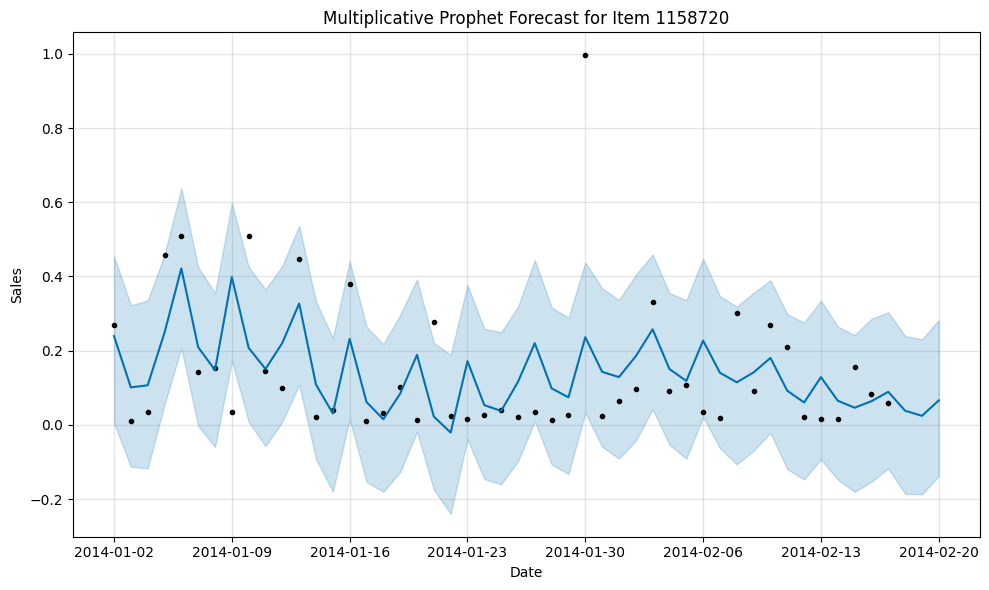

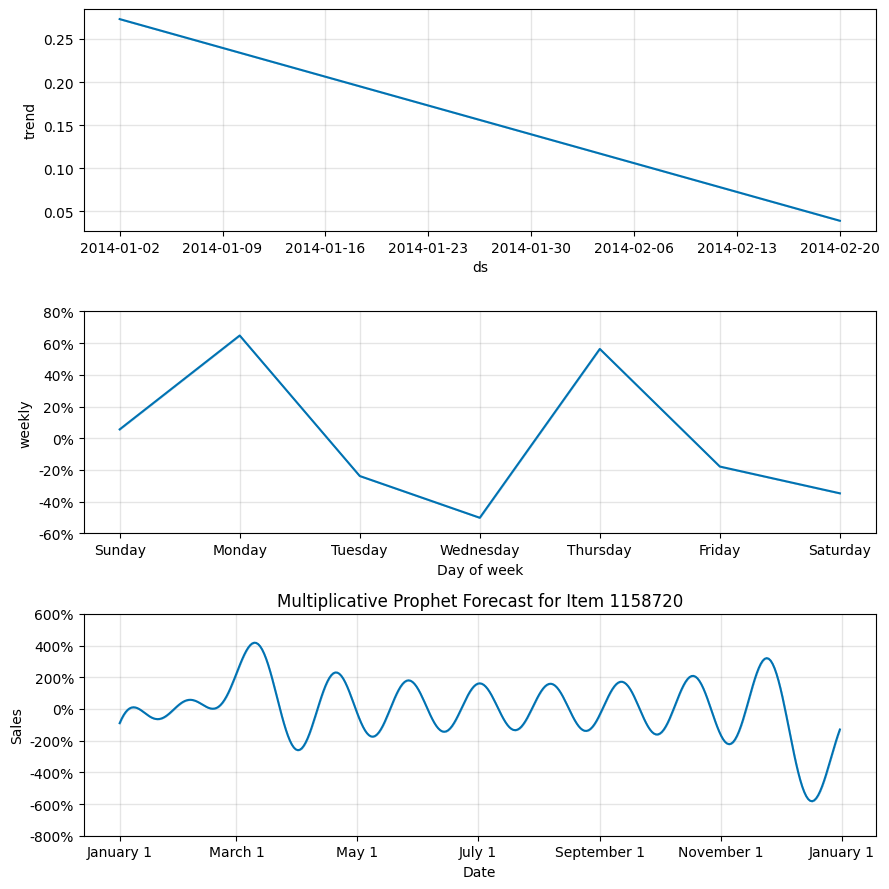

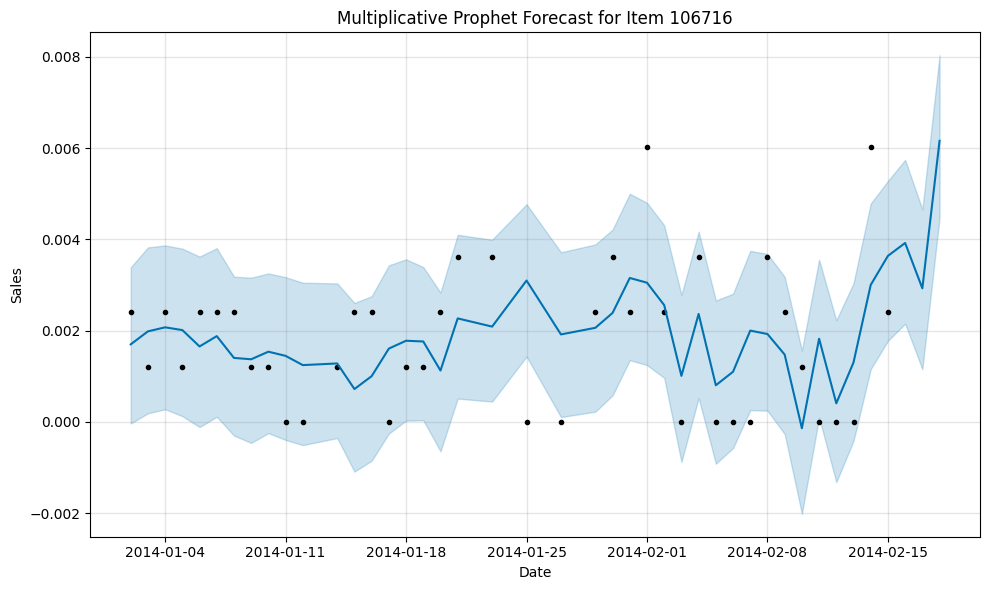

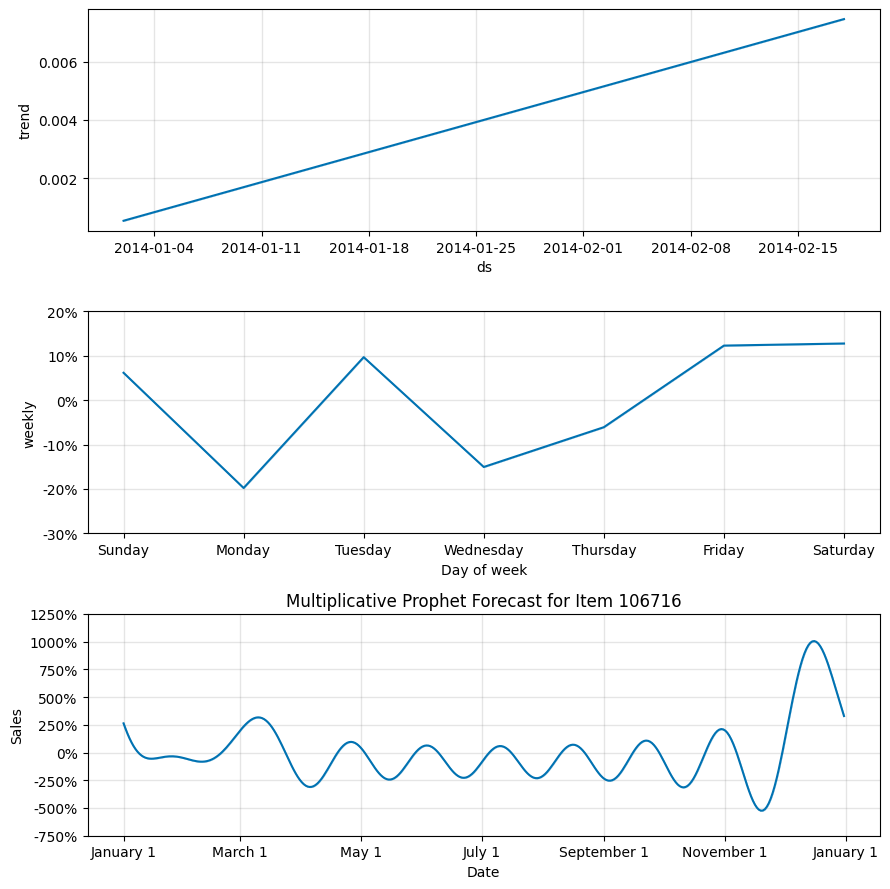

In [191]:
#future = model.make_future_dataframe(periods = 3,freq='D')

future_1158720 = prophet_models[1158720].make_future_dataframe(periods=3, freq='D')

future_1158720.tail()

forecast_1158720 = prophet_models[1158720].predict(future_1158720)

forecast_1158720[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1 = prophet_models[1158720].plot(forecast_1158720)
plt.title('Multiplicative Prophet Forecast for Item 1158720')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()

plt.show()

fig2 = prophet_models[1158720].plot_components(forecast_1158720)
plt.title('Multiplicative Prophet Forecast for Item 1158720')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()

plt.show()

future_106716= prophet_models[106716].make_future_dataframe(periods=3, freq='D')

future_106716.tail()

forecast_106716 = prophet_models[106716].predict(future_106716)

forecast_106716[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1 = prophet_models[106716].plot(forecast_106716)
plt.title('Multiplicative Prophet Forecast for Item 106716')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()

plt.show()

fig2 = prophet_models[106716].plot_components(forecast_106716)
plt.title('Multiplicative Prophet Forecast for Item 106716')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()

plt.show()



#Step 5. Additive Prophet Model

DEBUG:cmdstanpy:input tempfile: /tmp/tmpt5ojjpic/lh4ot023.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt5ojjpic/6y_674rs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61751', 'data', 'file=/tmp/tmpt5ojjpic/lh4ot023.json', 'init=/tmp/tmpt5ojjpic/6y_674rs.json', 'output', 'file=/tmp/tmpt5ojjpic/prophet_modelsbnjy3e2/prophet_model-20250308201205.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:12:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Run ID: e233e6e0a51a4dadb8a05a1bc645cb49
Training Prophet model for item: 106716


20:12:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Forecasting completed for item: 106716
✅ 106716 - MAE: 9.78, MSE: 136.36, RMSE: 11.68 (Original Scale)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt5ojjpic/_puwnrtq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt5ojjpic/7xjbfx1x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61886', 'data', 'file=/tmp/tmpt5ojjpic/_puwnrtq.json', 'init=/tmp/tmpt5ojjpic/7xjbfx1x.json', 'output', 'file=/tmp/tmpt5ojjpic/prophet_modelzw5t3jlf/prophet_model-20250308201206.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:12:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Training Prophet model for item: 1158720


20:12:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Forecasting completed for item: 1158720
✅ 1158720 - MAE: 361.18, MSE: 208770.31, RMSE: 456.91 (Original Scale)
✅ All Prophet models successfully logged to MLflow!


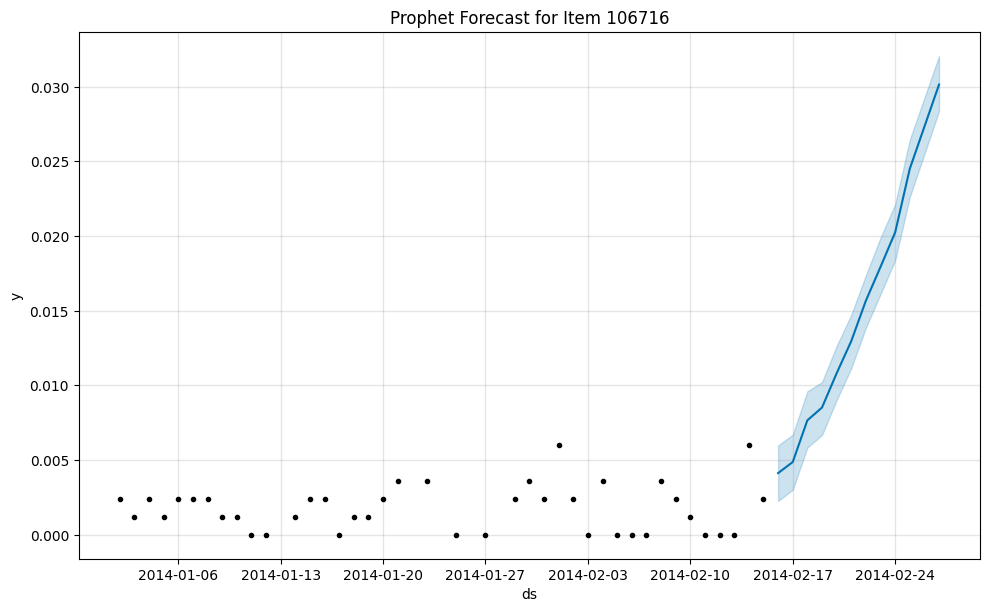

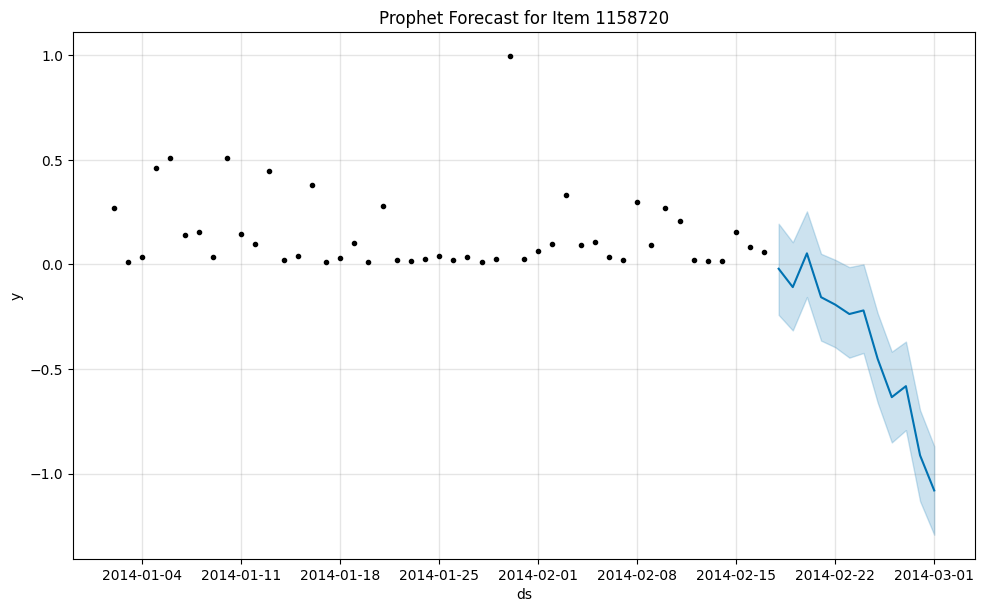

In [192]:
import os
import pickle
import mlflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from tempfile import TemporaryDirectory
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ✅ Start MLflow Run
with mlflow.start_run(run_name="Prophet_Models") as run:
    run_id = run.info.run_id
    print(f"Run ID: {run_id}")

    # Dictionaries to store Prophet models and forecasts
    prophet_models = {}
    forecasts = {}

    # List of external regressors (modify based on your dataset)
    external_regressors = ['promo', 'holiday', 'day_of_week', 'rolling_avg_7', 'rolling_avg_30']

    # ✅ Loop through each unique item (MODEL UNCHANGED)
    for item in unique_items:
        print(f"Training Prophet model for item: {item}")

        # ✅ Extract dataset for the specific item
        item_data = df_copy[df_copy['item_nbr'] == item].copy()
        item_data = item_data.rename(columns={'date': 'ds', 'unit_sales': 'y'})  # Prophet format

        # ✅ Ensure correct alignment between test data and predictions
        train_size = len(y_train_items[item])  # Number of training samples
        test_size = len(y_test_items[item])  # Number of test samples

        # ✅ Extract correct test dates from the dataset
        test_dates = item_data['ds'].iloc[train_size:train_size + test_size].values

        # ✅ Create Prophet model (NO CHANGES)
        model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False,
            seasonality_mode='additive'
        )

        # ✅ Add external regressors
        for reg in external_regressors:
            if reg in item_data.columns:
                model.add_regressor(reg)

        # ✅ Fit the model
        model.fit(item_data.iloc[:train_size])  # Train only on train_data

        # ✅ Create `future` dataframe that exactly matches test set dates
        future = pd.DataFrame({'ds': test_dates})

        # ✅ Add regressors for test period
        for reg in external_regressors:
            if reg in item_data.columns:
                future[reg] = item_data[reg].iloc[train_size:train_size + test_size].values

        # ✅ Generate forecast
        forecast = model.predict(future)

        # ✅ Store trained model & forecast
        prophet_models[item] = model
        forecasts[item] = forecast
        print(f"✅ Forecasting completed for item: {item}")

        # ✅ Reverse MinMax Scaling (Back to Original Scale)
        test_actuals_scaled = np.array(y_test_items[item]).reshape(-1, 1)
        test_predictions_scaled = forecast['yhat'].values.reshape(-1, 1)

        test_actuals_original = scaler.inverse_transform(test_actuals_scaled).flatten()
        test_predictions_original = scaler.inverse_transform(test_predictions_scaled).flatten()

        # ✅ Compute Metrics **on the full test set (original scale)**
        if len(test_actuals_original) == len(test_predictions_original):  # ✅ Ensure proper length match
            mae = mean_absolute_error(test_actuals_original, test_predictions_original)
            mse = mean_squared_error(test_actuals_original, test_predictions_original)
            rmse = np.sqrt(mse)

            # ✅ Log properly scaled metrics to MLflow
            mlflow.log_metric(f"MAE_{item}", round(mae, 2))
            mlflow.log_metric(f"MSE_{item}", round(mse, 2))
            mlflow.log_metric(f"RMSE_{item}", round(rmse, 2))

            print(f"✅ {item} - MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f} (Original Scale)")

        else:
            print(f"⚠️ Error: test_actuals and test_predictions have different lengths! Skipping logging for this item.")

        # ✅ Prophet's Built-in Visualization
        fig = model.plot(forecast)
        plt.title(f"Prophet Forecast for Item {item}")

        # ✅ Save and log plots
        plot_path = f"prophet_forecast_item_{item}.png"
        fig.savefig(plot_path)
        mlflow.log_artifact(plot_path, artifact_path="plots")

        # ✅ Save the trained model
        with TemporaryDirectory() as tmp_dir:
            model_path = os.path.join(tmp_dir, f"prophet_model_item_{item}.pkl")
            with open(model_path, "wb") as f:
                pickle.dump(model, f)
            mlflow.log_artifact(model_path, artifact_path="models")

    print("✅ All Prophet models successfully logged to MLflow!")


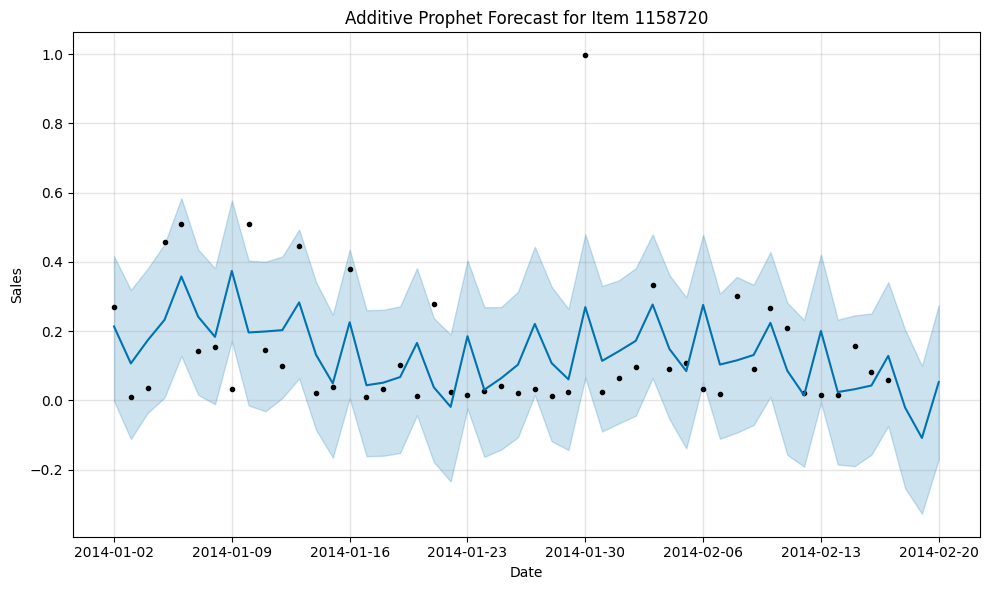

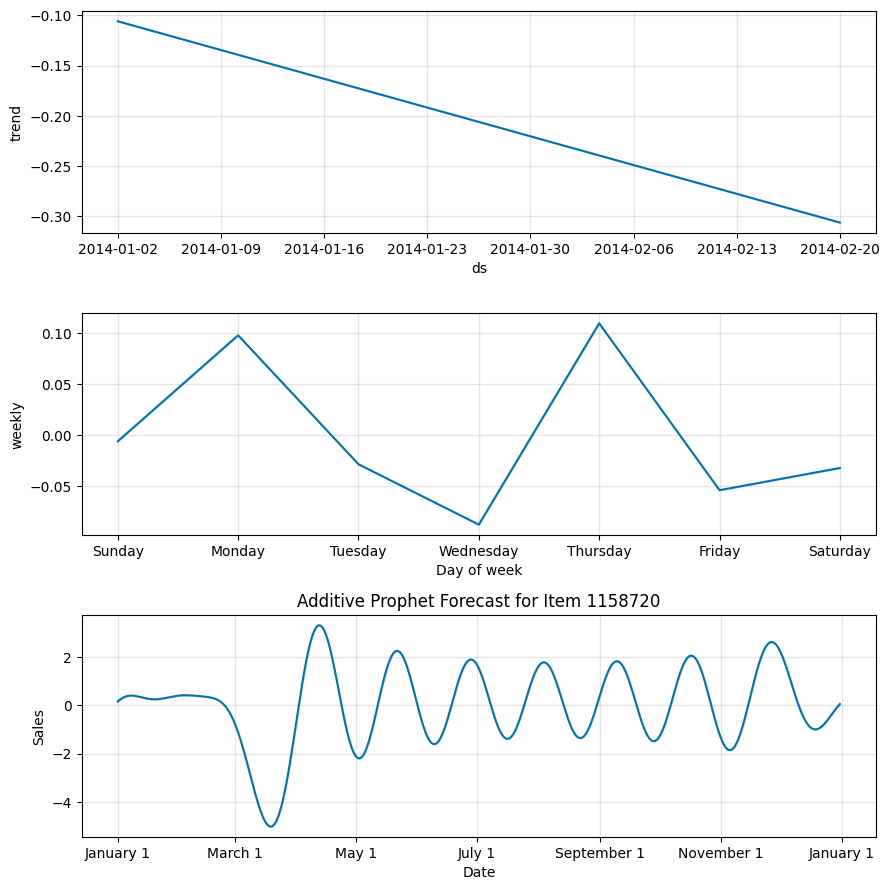

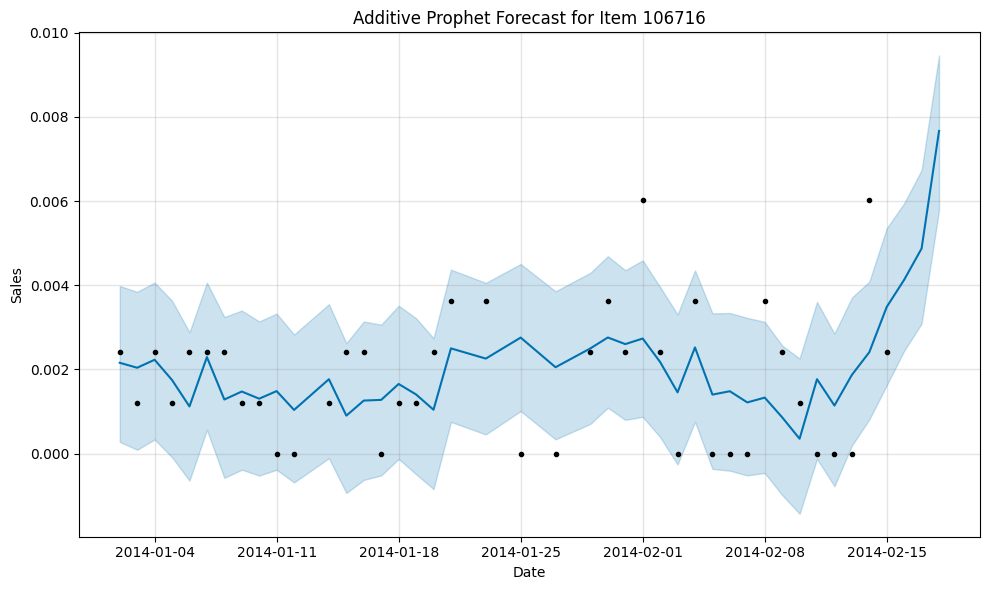

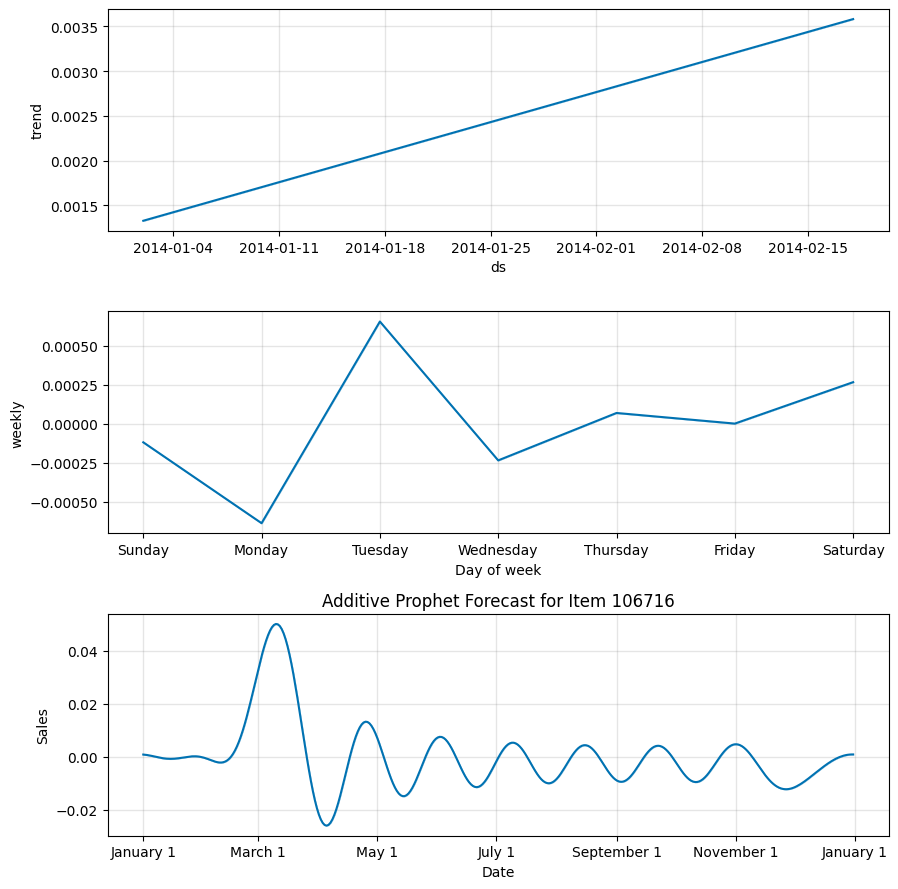

In [193]:
#future = model.make_future_dataframe(periods = 3,freq='D')

future_1158720 = prophet_models[1158720].make_future_dataframe(periods=3, freq='D')

future_1158720.tail()

forecast_1158720 = prophet_models[1158720].predict(future_1158720)

forecast_1158720[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1 = prophet_models[1158720].plot(forecast_1158720)

plt.title('Additive Prophet Forecast for Item 1158720')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()

plt.show()
fig2 = prophet_models[1158720].plot_components(forecast_1158720)

plt.title('Additive Prophet Forecast for Item 1158720')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()

plt.show()

future_106716= prophet_models[106716].make_future_dataframe(periods=3, freq='D')

future_106716.tail()

forecast_106716 = prophet_models[106716].predict(future_106716)

forecast_106716[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1 = prophet_models[106716].plot(forecast_106716)

plt.title('Additive Prophet Forecast for Item 106716')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()

plt.show()

fig2 = prophet_models[106716].plot_components(forecast_106716)

plt.title('Additive Prophet Forecast for Item 106716')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()

plt.show()



 Visualizing Prophet Forecasts

<Figure size 1400x700 with 0 Axes>

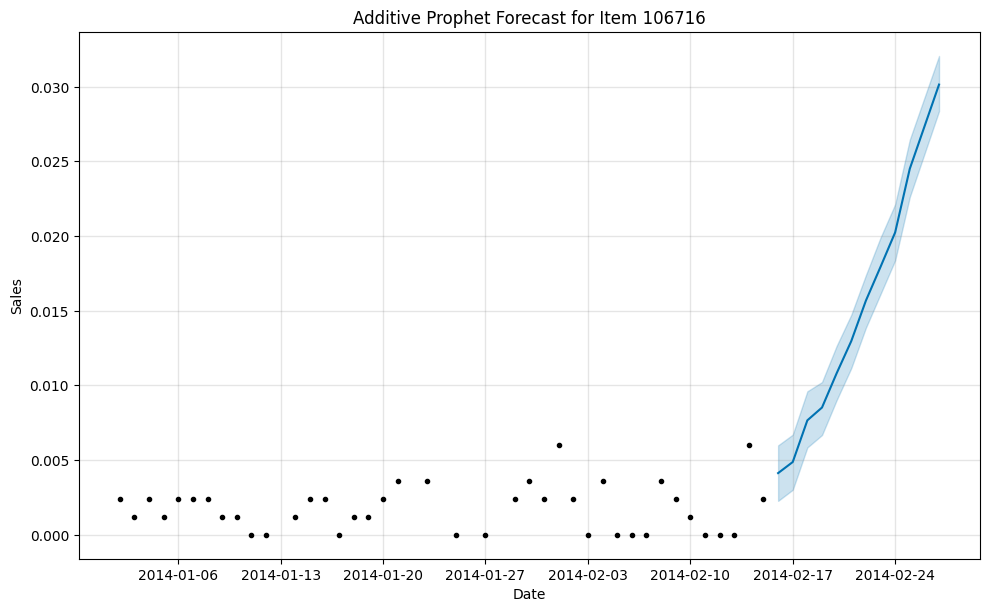

<Figure size 1400x700 with 0 Axes>

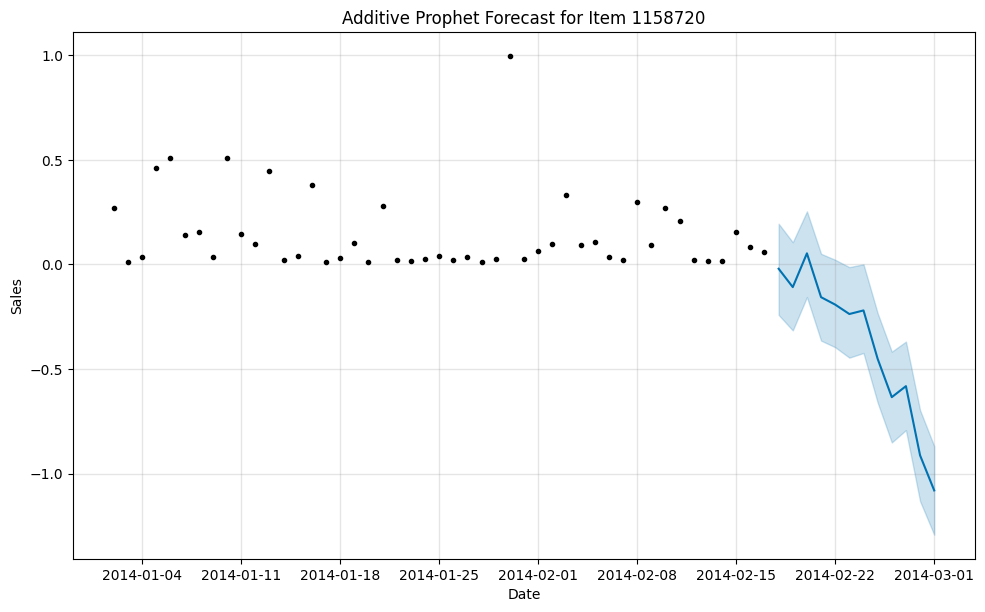

Visualization completed for all items.


In [194]:
# Function to visualize Prophet forecast
def plot_prophet_forecast(item, model, forecast):
    plt.figure(figsize=(14, 7))
    model.plot(forecast)
    plt.title(f'Additive Prophet Forecast for Item {item}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

# Loop through each item to visualize
for item in unique_items:
    plot_prophet_forecast(item, prophet_models[item], forecasts[item])

print("Visualization completed for all items.")


# Step 6. Integrating Holidays into the Prophet Model

In [195]:
#open holidays dataset
df_holidays = pd.read_csv("/content/holidays_events.csv")

In [196]:
df_holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


#Step 1: Prepare the Holiday Data

Prophet expects holidays in this format:
holidays = pd.DataFrame({
    'holiday': 'event_name',
    'ds': 'YYYY-MM-DD'
})

In [197]:
# Ensure date column is in datetime format
df_holidays['date'] = pd.to_datetime(df_holidays['date'])

# Create a properly formatted holidays DataFrame for Prophet
prophet_holidays = df_holidays[['date', 'description']].rename(columns={'date': 'ds', 'description': 'holiday'})

# Prophet requires 'holiday' column to be a string
prophet_holidays['holiday'] = prophet_holidays['holiday'].astype(str)

# Display the reformatted holiday DataFrame
print(prophet_holidays.head())


          ds                        holiday
0 2012-03-02             Fundacion de Manta
1 2012-04-01  Provincializacion de Cotopaxi
2 2012-04-12            Fundacion de Cuenca
3 2012-04-14      Cantonizacion de Libertad
4 2012-04-21      Cantonizacion de Riobamba


# Step 2: Merge Holidays with Sales Data

In [198]:
# Convert sales data date to datetime
df['date'] = pd.to_datetime(df['date'])

# Merge with holiday data to get a holiday flag
df = df.merge(prophet_holidays, left_on='date', right_on='ds', how='left')

# If a date is a holiday, set flag to 1, else 0
df['holiday_flag'] = df['holiday'].notna().astype(int)

# Drop duplicate 'ds' column
df.drop(columns=['ds'], inplace=True)

# Print to verify changes
print(df[['date', 'holiday', 'holiday_flag']].head(10))


        date holiday  holiday_flag
0 2014-01-02     NaN             0
1 2014-01-02     NaN             0
2 2014-01-03     NaN             0
3 2014-01-03     NaN             0
4 2014-01-04     NaN             0
5 2014-01-04     NaN             0
6 2014-01-05     NaN             0
7 2014-01-05     NaN             0
8 2014-01-06     NaN             0
9 2014-01-06     NaN             0


#Step 3: Train Prophet with Holidays

In [199]:
print(item_data.isnull().sum())


id                 0
ds                 0
store_nbr          0
item_nbr           0
y                  0
onpromotion        0
family             0
class              0
perishable         0
outlier_flag       0
holiday_flag       0
expanding_mean     0
lag_7              1
lag_30             3
rolling_std_7      1
lag_1              0
lag_2              0
lag_5              1
lag_10             3
lag_12            10
rolling_mean_7     1
dcoilwtico         0
dtype: int64


In [200]:
import pandas as pd
import numpy as np

# List of lag features to fill
lag_cols = ['lag_7', 'lag_30', 'rolling_std_7', 'lag_1', 'lag_2', 'lag_5', 'lag_10', 'lag_12', 'rolling_mean_7']

# Step 1: Fill missing values with the column mean (for initial NaNs)
for col in lag_cols:
    df[col] = df[col].fillna(df[col].mean())

# Step 2: Fill remaining NaNs with rolling mean (7-day window)
for col in lag_cols:
    df[col] = df[col].fillna(df[col].rolling(window=7, min_periods=1).mean())

# Step 3: Interpolate remaining missing values (linear method)
df[lag_cols] = df[lag_cols].interpolate(method='linear')
df['dcoilwtico'] = df['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')


# Step 4: Final check to ensure no NaNs remain
print(df.isnull().sum())  # Should show 0 missing values





id                  0
date                0
store_nbr           0
item_nbr            0
unit_sales          0
onpromotion         0
family              0
class               0
perishable          0
outlier_flag        0
holiday_flag        0
expanding_mean      0
lag_7               0
lag_30              0
rolling_std_7       0
lag_1               0
lag_2               0
lag_5               0
lag_10              0
lag_12              0
rolling_mean_7      0
dcoilwtico          0
holiday           164
dtype: int64


<ipython-input-200-9bd4abcd5675>:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['dcoilwtico'] = df['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')


Run ID: 71e3fbec4aa7406cbb41796d973bcbcc
Training Prophet model for item: 106716


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt5ojjpic/z1icalkk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt5ojjpic/lnd88lk4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78437', 'data', 'file=/tmp/tmpt5ojjpic/z1icalkk.json', 'init=/tmp/tmpt5ojjpic/lnd88lk4.json', 'output', 'file=/tmp/tmpt5ojjpic/prophet_modele0wwrtty/prophet_model-20250308201219.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:12:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:12:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Forecasting completed for item: 106716
✅ 106716 - MAE: 1.09, MSE: 2.46, RMSE: 1.57
Training Prophet model for item: 1158720


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt5ojjpic/5inz93y6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt5ojjpic/6icznbev.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13221', 'data', 'file=/tmp/tmpt5ojjpic/5inz93y6.json', 'init=/tmp/tmpt5ojjpic/6icznbev.json', 'output', 'file=/tmp/tmpt5ojjpic/prophet_modelf8pazk2w/prophet_model-20250308201227.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:12:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:12:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Forecasting completed for item: 1158720
✅ 1158720 - MAE: 35.00, MSE: 2551.82, RMSE: 50.52
✅ All Prophet models successfully logged to MLflow!


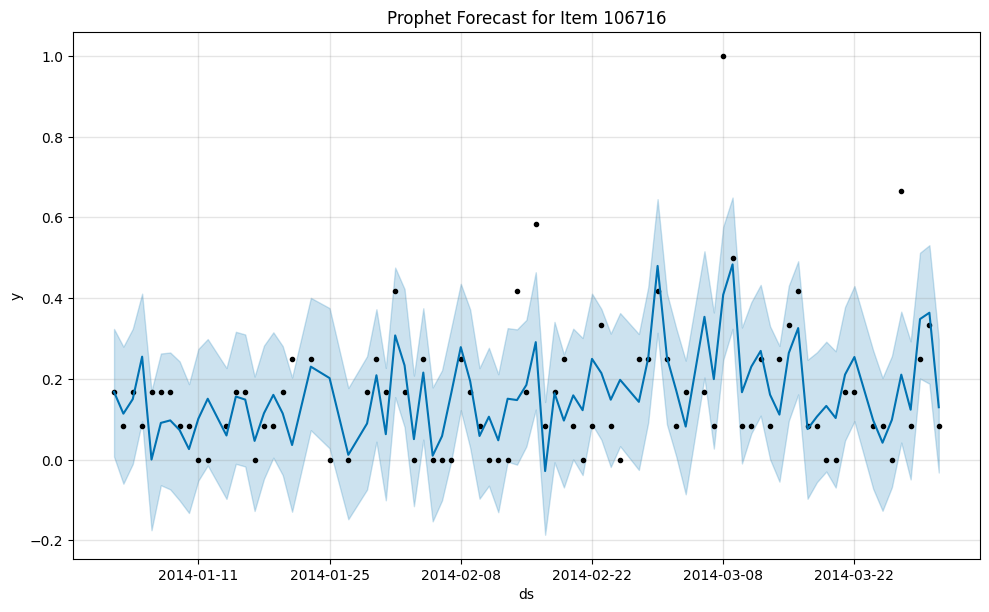

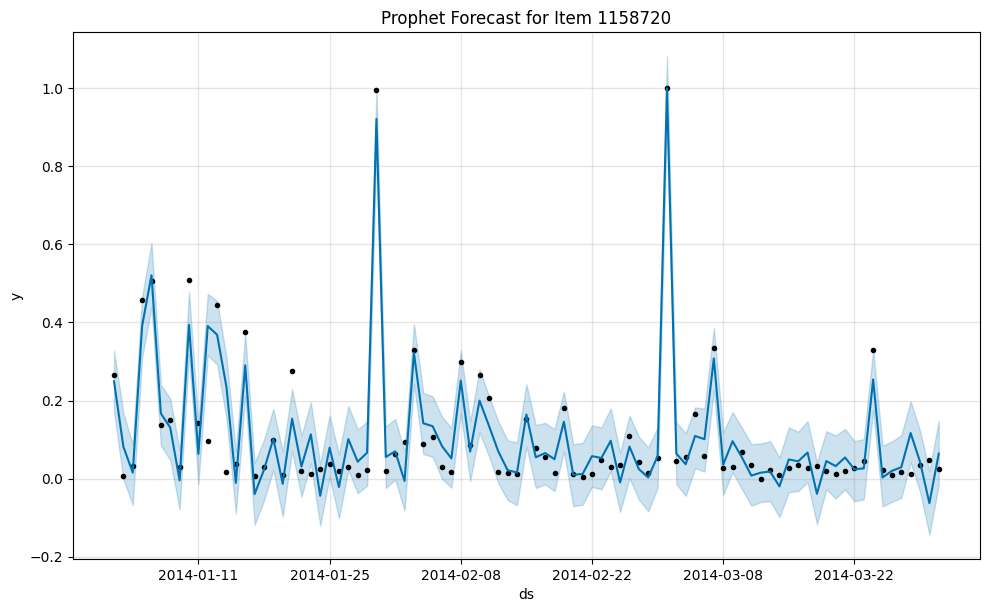

In [201]:
import os
import pickle
import mlflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from tempfile import TemporaryDirectory
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ✅ Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# ✅ Start MLflow Run
with mlflow.start_run(run_name="Prophet_Models_Custom") as run:
    run_id = run.info.run_id
    print(f"Run ID: {run_id}")

    # Dictionaries to store models and forecasts
    prophet_models = {}
    forecasts = {}

    # List of external regressors
    external_regressors = ['onpromotion', 'expanding_mean', 'lag_7', 'lag_30',
                           'rolling_std_7', 'rolling_mean_7', 'dcoilwtico', 'holiday_flag']

    # Rename holidays column for Prophet
    holidays = prophet_holidays.rename(columns={'ds': 'date'})

    for item in unique_items:
        print(f"Training Prophet model for item: {item}")

        # ✅ Filter data for the specific item
        item_data = df[df['item_nbr'] == item].copy()

        # ✅ Normalize 'unit_sales' using MinMaxScaler
        item_data['unit_sales'] = scaler.fit_transform(item_data[['unit_sales']])

        # ✅ Rename columns for Prophet format
        item_data = item_data.rename(columns={'date': 'ds', 'unit_sales': 'y'})

        # ✅ Retrieve hyperparameters
        params = prophet_params.get(item, {
            "changepoint_prior_scale": 0.05,
            "seasonality_prior_scale": 10,
            "holidays_prior_scale": 15,
            "fourier_order": 6
        })

        # ✅ Create Prophet model
        model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False,
            seasonality_mode='additive',
            holidays=prophet_holidays,
            changepoint_prior_scale=params["changepoint_prior_scale"],
            seasonality_prior_scale=params["seasonality_prior_scale"],
            holidays_prior_scale=params["holidays_prior_scale"]
        )

        # Add custom seasonality
        model.add_seasonality(name='monthly', period=3, fourier_order=params["fourier_order"])

        # Add external regressors
        for reg in external_regressors:
            if reg in item_data.columns:
                model.add_regressor(reg)

        # ✅ Fit the model
        model.fit(item_data)

        # ✅ Generate forecast for the entire dataset
        future = item_data[['ds']].copy()  # Use full dataset for forecasting
        for reg in external_regressors:
            if reg in item_data.columns:
                future[reg] = item_data[reg].values

        forecast = model.predict(future)

        # ✅ Store trained model and forecast
        prophet_models[item] = model
        forecasts[item] = forecast

        print(f"✅ Forecasting completed for item: {item}")

        # ✅ Compute Metrics with Inverse Scaling
        test_actuals = item_data['y'].values
        test_predictions = forecast['yhat'].values

        if len(test_actuals) == len(test_predictions):
            # Reverse scaling before computing metrics
            test_actuals = scaler.inverse_transform(test_actuals.reshape(-1, 1)).flatten()
            test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()

            mae = mean_absolute_error(test_actuals, test_predictions)
            mse = mean_squared_error(test_actuals, test_predictions)
            rmse = np.sqrt(mse)

            # ✅ Log metrics to MLflow
            mlflow.log_metric(f"MAE_{item}", round(mae, 2))
            mlflow.log_metric(f"MSE_{item}", round(mse, 2))
            mlflow.log_metric(f"RMSE_{item}", round(rmse, 2))

            print(f"✅ {item} - MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")
        else:
            print(f"⚠️ Error: test_actuals and test_predictions have different lengths!")

        # ✅ Prophet Built-in Visualization
        fig = model.plot(forecast)
        plt.title(f"Prophet Forecast for Item {item}")

        # ✅ Save and log plots
        plot_path = f"prophet_forecast_item_{item}.png"
        fig.savefig(plot_path)
        mlflow.log_artifact(plot_path, artifact_path="plots")

        # ✅ Save the trained model
        with TemporaryDirectory() as tmp_dir:
            model_path = os.path.join(tmp_dir, f"prophet_model_item_{item}.pkl")
            with open(model_path, "wb") as f:
                pickle.dump(model, f)
            mlflow.log_artifact(model_path, artifact_path="models")

    print("✅ All Prophet models successfully logged to MLflow!")


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt5ojjpic/ecqh6cr6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt5ojjpic/ygo14onb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20301', 'data', 'file=/tmp/tmpt5ojjpic/ecqh6cr6.json', 'init=/tmp/tmpt5ojjpic/ygo14onb.json', 'output', 'file=/tmp/tmpt5ojjpic/prophet_model6ibs6mqo/prophet_model-20250308201233.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:12:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Run ID: 68bdd8c95332423791238f8ff7dd2a77
Training Optimized Prophet model for item: 106716


20:12:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Forecasting completed for item: 106716
✅ 106716 - MAE: 1.08, MSE: 2.41, RMSE: 1.55


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt5ojjpic/ecklywc4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt5ojjpic/dwodox84.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19078', 'data', 'file=/tmp/tmpt5ojjpic/ecklywc4.json', 'init=/tmp/tmpt5ojjpic/dwodox84.json', 'output', 'file=/tmp/tmpt5ojjpic/prophet_modelb97suv_0/prophet_model-20250308201235.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:12:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Training Optimized Prophet model for item: 1158720


20:12:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Forecasting completed for item: 1158720
✅ 1158720 - MAE: 35.11, MSE: 2540.93, RMSE: 50.41
✅ All Optimized Prophet models successfully logged to MLflow!


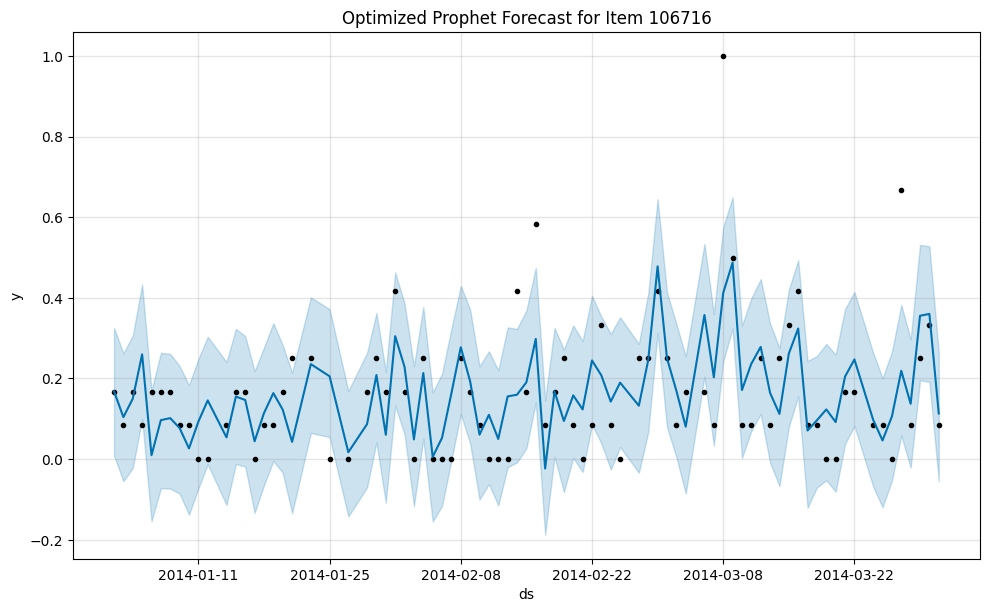

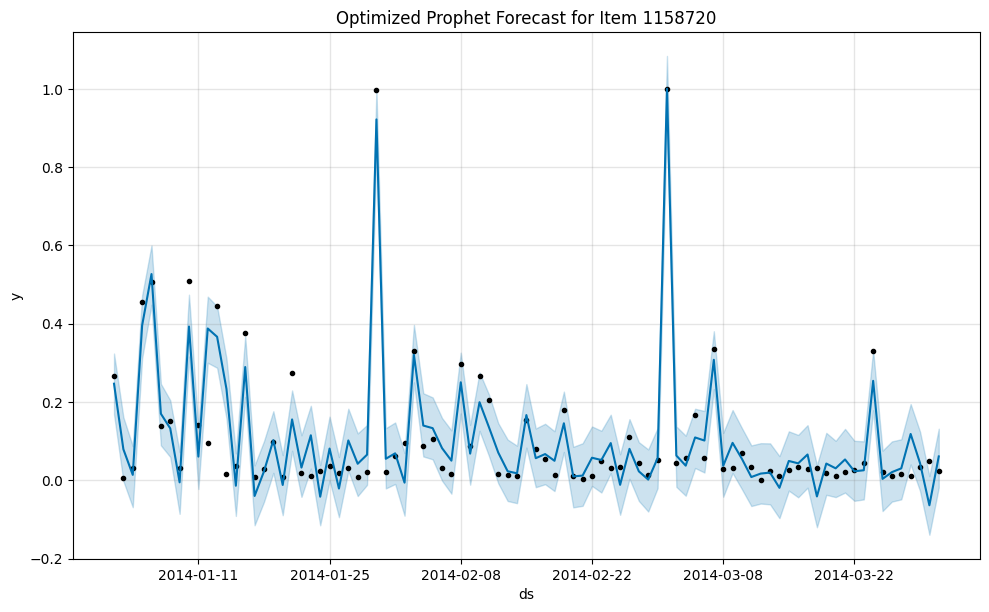

In [202]:
import os
import pickle
import mlflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from tempfile import TemporaryDirectory
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ✅ Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# ✅ Start MLflow Run
with mlflow.start_run(run_name="Prophet_Models_Optimized") as run:
    run_id = run.info.run_id
    print(f"Run ID: {run_id}")

    # Dictionaries to store models and forecasts
    prophet_params = {
        106716: {
            "changepoint_prior_scale": 0.01,
            "seasonality_prior_scale": 10,
            "holidays_prior_scale": 15,
            "fourier_order": 5
        },
        1158720: {
            "changepoint_prior_scale": 0.1,
            "seasonality_prior_scale": 15,
            "holidays_prior_scale": 20,
            "fourier_order": 12
        }
    }

    forecasts = {}

    # List of external regressors
    external_regressors = ['onpromotion', 'expanding_mean', 'lag_7', 'lag_30',
                           'rolling_std_7', 'rolling_mean_7', 'dcoilwtico', 'holiday_flag']

    # Rename holidays column for Prophet
    holidays = prophet_holidays.rename(columns={'ds': 'date'})

    for item in unique_items:
        print(f"Training Optimized Prophet model for item: {item}")

        # ✅ Filter data for the specific item
        item_data = df[df['item_nbr'] == item].copy()

        # ✅ Normalize 'unit_sales' using MinMaxScaler
        item_data['unit_sales'] = scaler.fit_transform(item_data[['unit_sales']])

        # ✅ Rename columns for Prophet format
        item_data = item_data.rename(columns={'date': 'ds', 'unit_sales': 'y'})

        # ✅ Retrieve optimized hyperparameters for the specific item
        params = prophet_params[item]  # ✅ FIXED THIS LINE

        # ✅ Create Prophet model
        model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False,
            seasonality_mode='additive',
            holidays=prophet_holidays,
            changepoint_prior_scale=params["changepoint_prior_scale"],
            seasonality_prior_scale=params["seasonality_prior_scale"],
            holidays_prior_scale=params["holidays_prior_scale"]
        )

        # Add custom seasonality with item-specific Fourier order
        model.add_seasonality(name='monthly', period=3, fourier_order=params["fourier_order"])

        # Add external regressors
        for reg in external_regressors:
            if reg in item_data.columns:
                model.add_regressor(reg)

        # ✅ Fit the model
        model.fit(item_data)

        # ✅ Generate forecast for the entire dataset
        future = item_data[['ds']].copy()  # Use full dataset for forecasting
        for reg in external_regressors:
            if reg in item_data.columns:
                future[reg] = item_data[reg].values

        forecast = model.predict(future)

        # ✅ Store trained model and forecast
        prophet_models[item] = model
        forecasts[item] = forecast

        print(f"✅ Forecasting completed for item: {item}")

        # ✅ Compute Metrics with Inverse Scaling
        test_actuals = item_data['y'].values
        test_predictions = forecast['yhat'].values

        if len(test_actuals) == len(test_predictions):
            # Reverse scaling before computing metrics
            test_actuals = scaler.inverse_transform(test_actuals.reshape(-1, 1)).flatten()
            test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()

            mae = mean_absolute_error(test_actuals, test_predictions)
            mse = mean_squared_error(test_actuals, test_predictions)
            rmse = np.sqrt(mse)

            # ✅ Log metrics to MLflow
            mlflow.log_metric(f"MAE_{item}", round(mae, 2))
            mlflow.log_metric(f"MSE_{item}", round(mse, 2))
            mlflow.log_metric(f"RMSE_{item}", round(rmse, 2))

            print(f"✅ {item} - MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")
        else:
            print(f"⚠️ Error: test_actuals and test_predictions have different lengths!")

        # ✅ Prophet Built-in Visualization
        fig = model.plot(forecast)
        plt.title(f"Optimized Prophet Forecast for Item {item}")

        # ✅ Save and log plots
        plot_path = f"prophet_forecast_item_{item}.png"
        fig.savefig(plot_path)
        mlflow.log_artifact(plot_path, artifact_path="plots")

        # ✅ Save the trained model
        with TemporaryDirectory() as tmp_dir:
            model_path = os.path.join(tmp_dir, f"prophet_model_item_{item}.pkl")
            with open(model_path, "wb") as f:
                pickle.dump(model, f)
            mlflow.log_artifact(model_path, artifact_path="models")

    print("✅ All Optimized Prophet models successfully logged to MLflow!")


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt5ojjpic/1_6ooqho.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt5ojjpic/ltkwprb0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75492', 'data', 'file=/tmp/tmpt5ojjpic/1_6ooqho.json', 'init=/tmp/tmpt5ojjpic/ltkwprb0.json', 'output', 'file=/tmp/tmpt5ojjpic/prophet_modelv7q05wxu/prophet_model-20250308201238.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:12:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Run ID: 2309e8a636e34a72a07aac4b70218630
Training Improved Prophet model for item: 106716


20:12:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Forecasting completed for item: 106716
✅ 106716 - MAE: 1.09, MSE: 2.44, RMSE: 1.56


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt5ojjpic/1xgg4g3c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt5ojjpic/uyx05ef4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13933', 'data', 'file=/tmp/tmpt5ojjpic/1xgg4g3c.json', 'init=/tmp/tmpt5ojjpic/uyx05ef4.json', 'output', 'file=/tmp/tmpt5ojjpic/prophet_modelmjifjwbo/prophet_model-20250308201240.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:12:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Training Improved Prophet model for item: 1158720


20:12:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Forecasting completed for item: 1158720
✅ 1158720 - MAE: 35.08, MSE: 2546.31, RMSE: 50.46
✅ All Improved Prophet models successfully logged to MLflow!


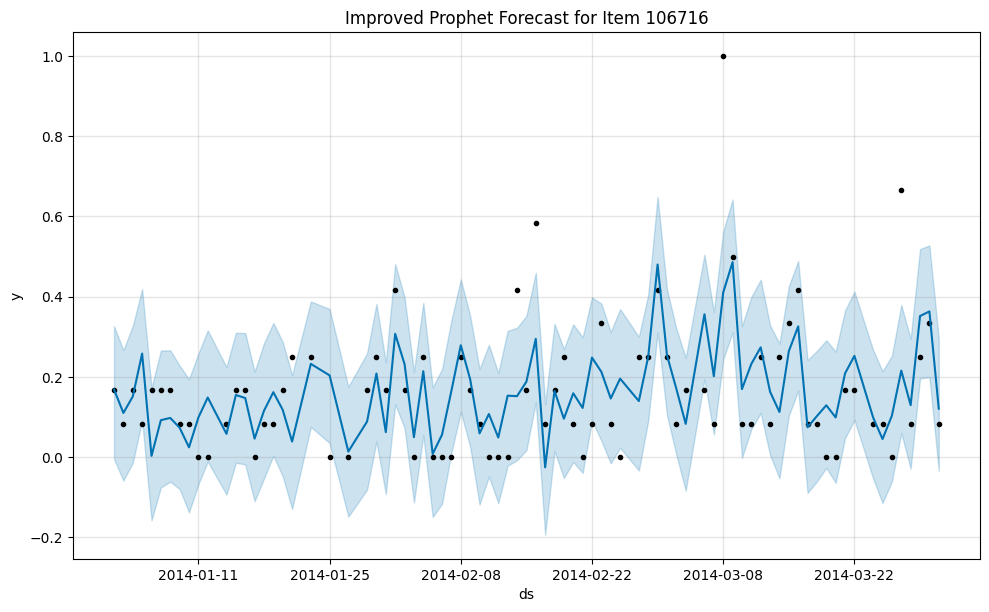

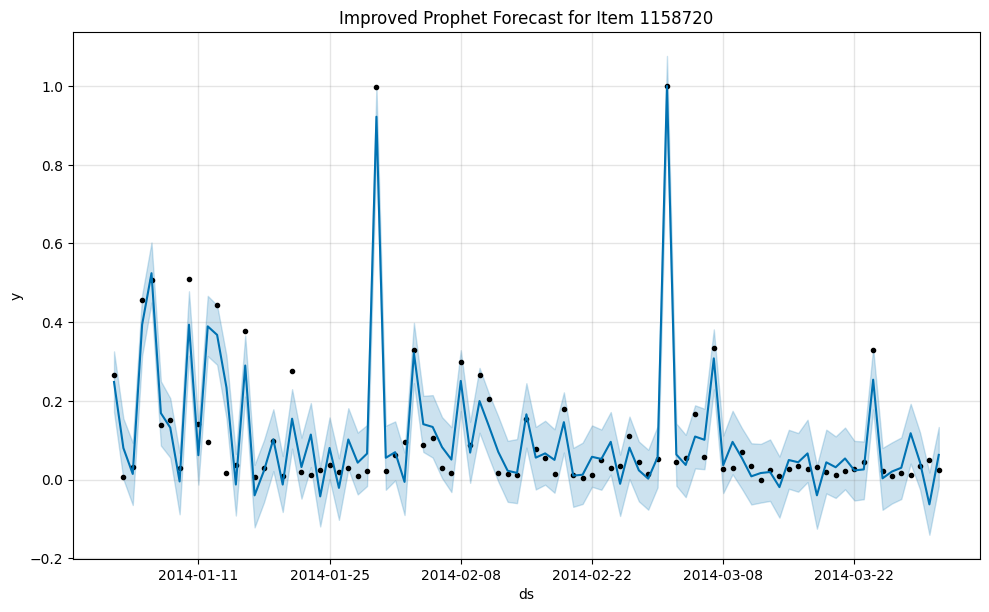

In [203]:
import os
import pickle
import mlflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from tempfile import TemporaryDirectory
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ✅ Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# ✅ Start MLflow Run
with mlflow.start_run(run_name="Prophet_Models_Improved") as run:
    run_id = run.info.run_id
    print(f"Run ID: {run_id}")

    # Updated Hyperparameters
    prophet_params = {
        106716: {
            "changepoint_prior_scale": 0.005,  # Smoother trend transitions
            "seasonality_prior_scale": 8,  # More seasonality flexibility
            "holidays_prior_scale": 10,  # Less aggressive holiday effects
            "fourier_order": 6  # Slightly higher seasonality oscillation
        },
        1158720: {
            "changepoint_prior_scale": 0.05,  # More trend flexibility
            "seasonality_prior_scale": 12,  # More seasonality allowed
            "holidays_prior_scale": 18,  # Reduce holiday overfitting
            "fourier_order": 15  # Capture more seasonal oscillations
        }
    }

    forecasts = {}

    # List of external regressors
    external_regressors = ['onpromotion', 'expanding_mean', 'lag_7', 'lag_30',
                           'rolling_std_7', 'rolling_mean_7', 'dcoilwtico', 'holiday_flag']

    # Rename holidays column for Prophet
    holidays = prophet_holidays.rename(columns={'ds': 'date'})

    for item in unique_items:
        print(f"Training Improved Prophet model for item: {item}")

        # ✅ Filter data for the specific item
        item_data = df[df['item_nbr'] == item].copy()

        # ✅ Normalize 'unit_sales' using MinMaxScaler
        item_data['unit_sales'] = scaler.fit_transform(item_data[['unit_sales']])

        # ✅ Rename columns for Prophet format
        item_data = item_data.rename(columns={'date': 'ds', 'unit_sales': 'y'})

        # ✅ Retrieve optimized hyperparameters for the specific item
        params = prophet_params[item]

        # ✅ Create Prophet model
        model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False,
            seasonality_mode='additive',
            holidays=prophet_holidays,
            changepoint_prior_scale=params["changepoint_prior_scale"],
            seasonality_prior_scale=params["seasonality_prior_scale"],
            holidays_prior_scale=params["holidays_prior_scale"]
        )

        # Add custom seasonality with item-specific Fourier order
        model.add_seasonality(name='monthly', period=3, fourier_order=params["fourier_order"])

        # Add external regressors
        for reg in external_regressors:
            if reg in item_data.columns:
                model.add_regressor(reg)

        # ✅ Fit the model
        model.fit(item_data)

        # ✅ Generate forecast for the entire dataset
        future = item_data[['ds']].copy()  # Use full dataset for forecasting
        for reg in external_regressors:
            if reg in item_data.columns:
                future[reg] = item_data[reg].values

        forecast = model.predict(future)

        # ✅ Store trained model and forecast
        prophet_models[item] = model
        forecasts[item] = forecast

        print(f"✅ Forecasting completed for item: {item}")

        # ✅ Compute Metrics with Inverse Scaling
        test_actuals = item_data['y'].values
        test_predictions = forecast['yhat'].values

        if len(test_actuals) == len(test_predictions):
            # Reverse scaling before computing metrics
            test_actuals = scaler.inverse_transform(test_actuals.reshape(-1, 1)).flatten()
            test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()

            mae = mean_absolute_error(test_actuals, test_predictions)
            mse = mean_squared_error(test_actuals, test_predictions)
            rmse = np.sqrt(mse)

            # ✅ Log metrics to MLflow
            mlflow.log_metric(f"MAE_{item}", round(mae, 2))
            mlflow.log_metric(f"MSE_{item}", round(mse, 2))
            mlflow.log_metric(f"RMSE_{item}", round(rmse, 2))

            print(f"✅ {item} - MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")
        else:
            print(f"⚠️ Error: test_actuals and test_predictions have different lengths!")

        # ✅ Prophet Built-in Visualization
        fig = model.plot(forecast)
        plt.title(f"Improved Prophet Forecast for Item {item}")

        # ✅ Save and log plots
        plot_path = f"prophet_forecast_item_{item}.png"
        fig.savefig(plot_path)
        mlflow.log_artifact(plot_path, artifact_path="plots")

        # ✅ Save the trained model
        with TemporaryDirectory() as tmp_dir:
            model_path = os.path.join(tmp_dir, f"prophet_model_item_{item}.pkl")
            with open(model_path, "wb") as f:
                pickle.dump(model, f)
            mlflow.log_artifact(model_path, artifact_path="models")

    print("✅ All Improved Prophet models successfully logged to MLflow!")


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt5ojjpic/eo1zbuve.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt5ojjpic/fsssklq_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50639', 'data', 'file=/tmp/tmpt5ojjpic/eo1zbuve.json', 'init=/tmp/tmpt5ojjpic/fsssklq_.json', 'output', 'file=/tmp/tmpt5ojjpic/prophet_modelkex3sq76/prophet_model-20250308201246.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:12:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Run ID: 714d45e21fc542bc88a1eecc56411d7d
Training Further Optimized Prophet model for item: 106716


20:12:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Forecasting completed for item: 106716
✅ 106716 - MAE: 1.09, MSE: 2.45, RMSE: 1.57


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt5ojjpic/li4n0vzc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt5ojjpic/0rlgza0s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11744', 'data', 'file=/tmp/tmpt5ojjpic/li4n0vzc.json', 'init=/tmp/tmpt5ojjpic/0rlgza0s.json', 'output', 'file=/tmp/tmpt5ojjpic/prophet_model1slvkuyh/prophet_model-20250308201251.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:12:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Training Further Optimized Prophet model for item: 1158720


20:12:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Forecasting completed for item: 1158720
✅ 1158720 - MAE: 35.04, MSE: 2549.01, RMSE: 50.49
✅ All Further Optimized Prophet models successfully logged to MLflow!


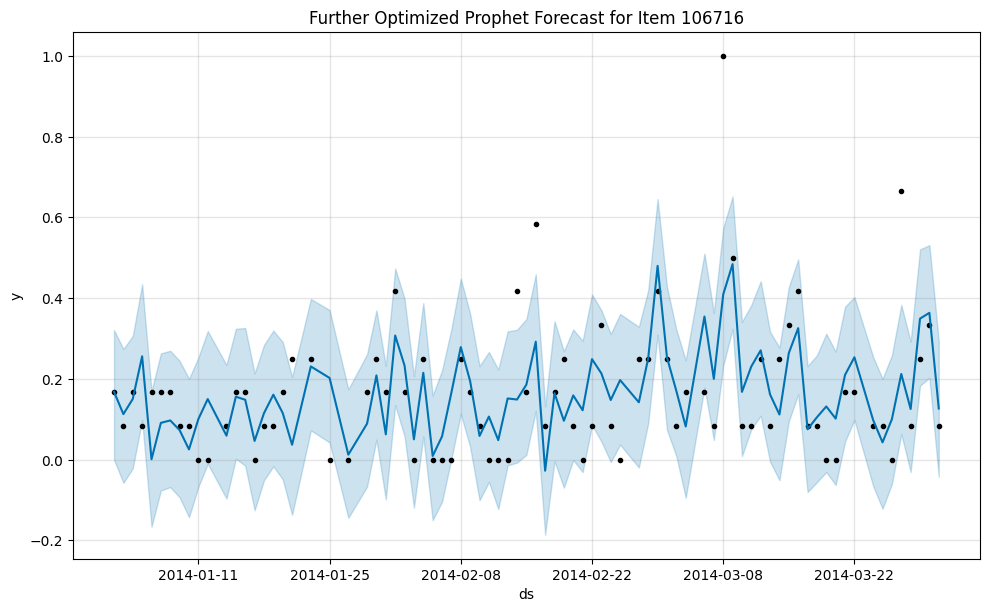

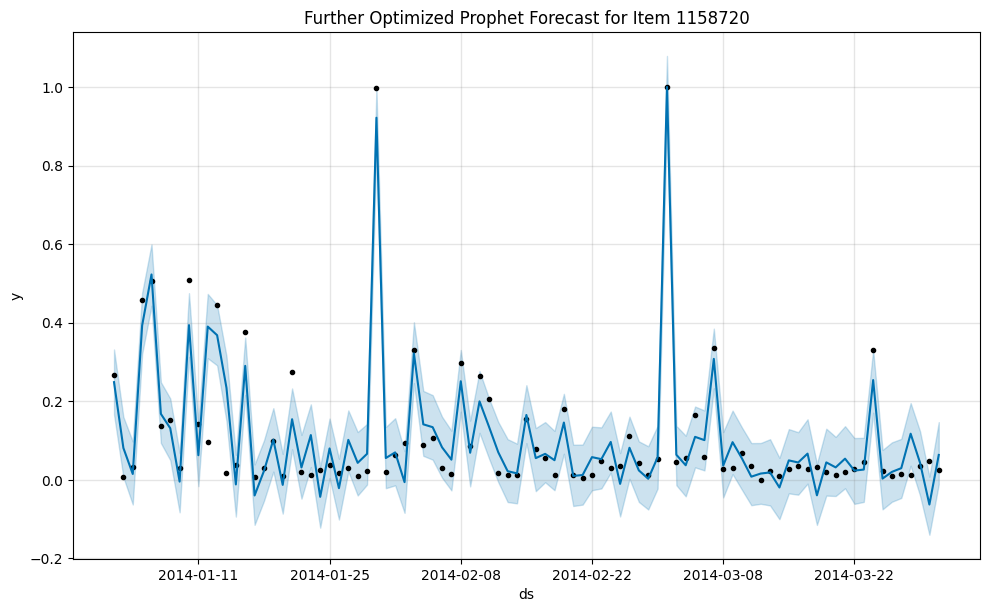

In [204]:
import os
import pickle
import mlflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from tempfile import TemporaryDirectory
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ✅ Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# ✅ Start MLflow Run
with mlflow.start_run(run_name="Prophet_Models_Further_Optimized") as run:
    run_id = run.info.run_id
    print(f"Run ID: {run_id}")

    # Further Optimized Hyperparameters
    prophet_params = {
        106716: {
            "changepoint_prior_scale": 0.004,  # Smoother trend transitions
            "seasonality_prior_scale": 7,  # Less aggressive seasonality
            "holidays_prior_scale": 8,  # Reduce exaggerated holiday effects
            "fourier_order": 4  # Less seasonal complexity
        },
        1158720: {
            "changepoint_prior_scale": 0.04,  # More realistic trend adjustments
            "seasonality_prior_scale": 11,  # Moderate seasonality
            "holidays_prior_scale": 16,  # Adjust holiday influence
            "fourier_order": 12  # Balance seasonal oscillations
        }
    }

    forecasts = {}

    # List of external regressors
    external_regressors = ['onpromotion', 'expanding_mean', 'lag_7', 'lag_30',
                           'rolling_std_7', 'rolling_mean_7', 'dcoilwtico', 'holiday_flag']

    # Rename holidays column for Prophet
    holidays = prophet_holidays.rename(columns={'ds': 'date'})

    for item in unique_items:
        print(f"Training Further Optimized Prophet model for item: {item}")

        # ✅ Filter data for the specific item
        item_data = df[df['item_nbr'] == item].copy()

        # ✅ Normalize 'unit_sales' using MinMaxScaler
        item_data['unit_sales'] = scaler.fit_transform(item_data[['unit_sales']])

        # ✅ Rename columns for Prophet format
        item_data = item_data.rename(columns={'date': 'ds', 'unit_sales': 'y'})

        # ✅ Retrieve further optimized hyperparameters for the specific item
        params = prophet_params[item]

        # ✅ Create Prophet model
        model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False,
            seasonality_mode='additive',
            holidays=prophet_holidays,
            changepoint_prior_scale=params["changepoint_prior_scale"],
            seasonality_prior_scale=params["seasonality_prior_scale"],
            holidays_prior_scale=params["holidays_prior_scale"]
        )

        # Add custom seasonality with item-specific Fourier order
        model.add_seasonality(name='monthly', period=3, fourier_order=params["fourier_order"])

        # Add external regressors
        for reg in external_regressors:
            if reg in item_data.columns:
                model.add_regressor(reg)

        # ✅ Fit the model
        model.fit(item_data)

        # ✅ Generate forecast for the entire dataset
        future = item_data[['ds']].copy()  # Use full dataset for forecasting
        for reg in external_regressors:
            if reg in item_data.columns:
                future[reg] = item_data[reg].values

        forecast = model.predict(future)

        # ✅ Store trained model and forecast
        prophet_models[item] = model
        forecasts[item] = forecast

        print(f"✅ Forecasting completed for item: {item}")

        # ✅ Compute Metrics with Inverse Scaling
        test_actuals = item_data['y'].values
        test_predictions = forecast['yhat'].values

        if len(test_actuals) == len(test_predictions):
            # Reverse scaling before computing metrics
            test_actuals = scaler.inverse_transform(test_actuals.reshape(-1, 1)).flatten()
            test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()

            mae = mean_absolute_error(test_actuals, test_predictions)
            mse = mean_squared_error(test_actuals, test_predictions)
            rmse = np.sqrt(mse)

            # ✅ Log metrics to MLflow
            mlflow.log_metric(f"MAE_{item}", round(mae, 2))
            mlflow.log_metric(f"MSE_{item}", round(mse, 2))
            mlflow.log_metric(f"RMSE_{item}", round(rmse, 2))

            print(f"✅ {item} - MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")
        else:
            print(f"⚠️ Error: test_actuals and test_predictions have different lengths!")

        # ✅ Prophet Built-in Visualization
        fig = model.plot(forecast)
        plt.title(f"Further Optimized Prophet Forecast for Item {item}")

        # ✅ Save and log plots
        plot_path = f"prophet_forecast_item_{item}.png"
        fig.savefig(plot_path)
        mlflow.log_artifact(plot_path, artifact_path="plots")

        # ✅ Save the trained model
        with TemporaryDirectory() as tmp_dir:
            model_path = os.path.join(tmp_dir, f"prophet_model_item_{item}.pkl")
            with open(model_path, "wb") as f:
                pickle.dump(model, f)
            mlflow.log_artifact(model_path, artifact_path="models")

    print("✅ All Further Optimized Prophet models successfully logged to MLflow!")


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt5ojjpic/pi_lmpgm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt5ojjpic/k0214z3h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56746', 'data', 'file=/tmp/tmpt5ojjpic/pi_lmpgm.json', 'init=/tmp/tmpt5ojjpic/k0214z3h.json', 'output', 'file=/tmp/tmpt5ojjpic/prophet_modely128vhhw/prophet_model-20250308201254.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:12:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Run ID: 80f301da17944f80b407dfd5e6845800
Training Final Optimized Prophet model for item: 106716


20:12:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Forecasting completed for item: 106716
✅ 106716 - MAE: 1.09, MSE: 2.46, RMSE: 1.57


DEBUG:cmdstanpy:input tempfile: /tmp/tmpt5ojjpic/br4cqbik.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt5ojjpic/_6fkseuz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46414', 'data', 'file=/tmp/tmpt5ojjpic/br4cqbik.json', 'init=/tmp/tmpt5ojjpic/_6fkseuz.json', 'output', 'file=/tmp/tmpt5ojjpic/prophet_model74_ccq6v/prophet_model-20250308201256.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:12:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Training Final Optimized Prophet model for item: 1158720


20:12:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Forecasting completed for item: 1158720
✅ 1158720 - MAE: 35.00, MSE: 2551.82, RMSE: 50.52
✅ All Final Optimized Prophet models successfully logged to MLflow!


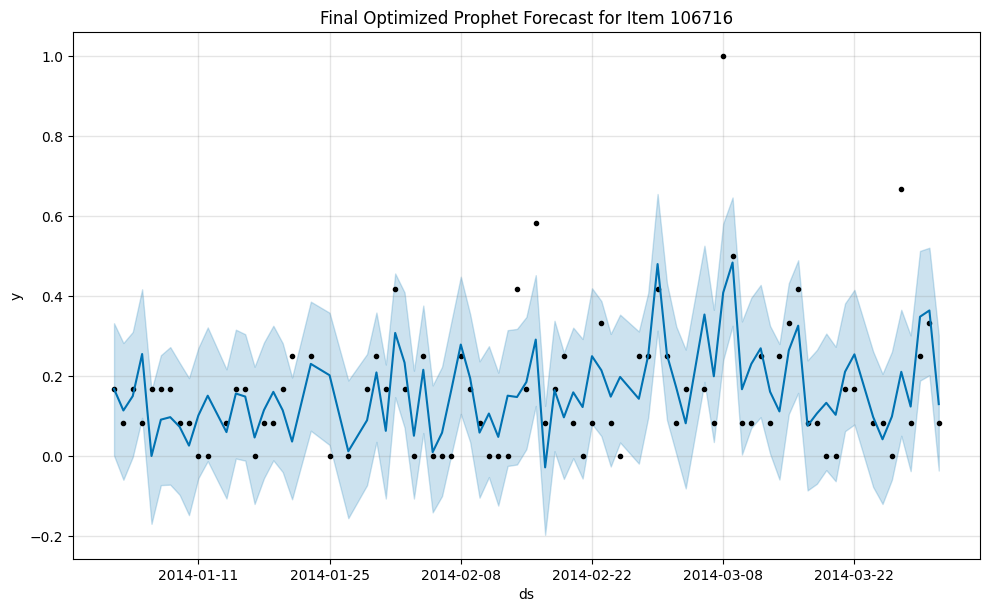

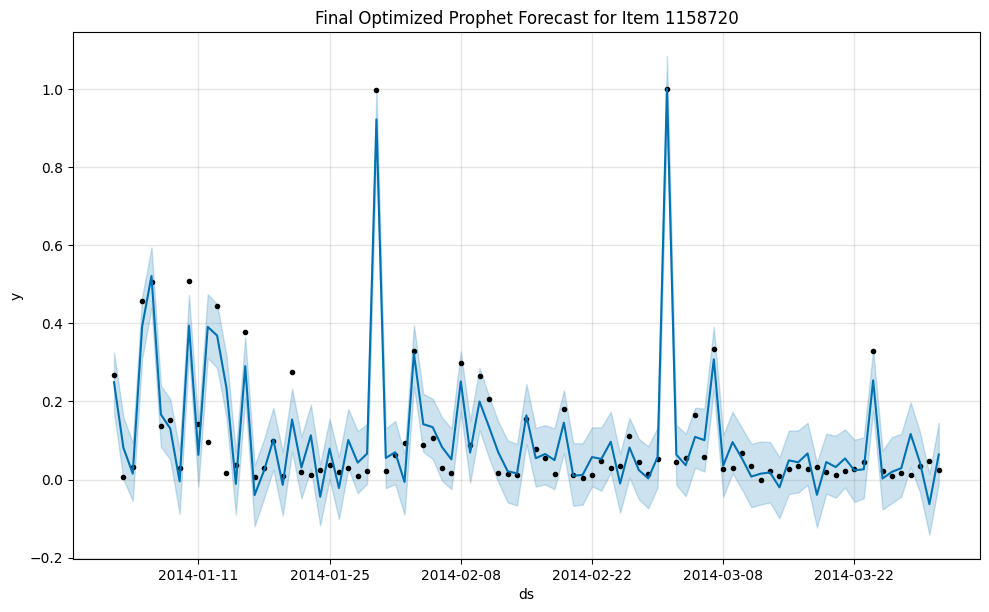

In [205]:
import os
import pickle
import mlflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from tempfile import TemporaryDirectory
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ✅ Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# ✅ Start MLflow Run
with mlflow.start_run(run_name="Prophet_Models_Final_Optimization") as run:
    run_id = run.info.run_id
    print(f"Run ID: {run_id}")

    # Final Optimized Hyperparameters
    prophet_params = {
        106716: {
            "changepoint_prior_scale": 0.0035,  # More stable trend
            "seasonality_prior_scale": 6.5,  # Reduce aggressive seasonality
            "holidays_prior_scale": 7.5,  # Prevent overreaction to holidays
            "fourier_order": 3  # Reduce unnecessary seasonal complexity
        },
        1158720: {
            "changepoint_prior_scale": 0.035,  # Reduce trend instability
            "seasonality_prior_scale": 10,  # Moderate seasonal adjustments
            "holidays_prior_scale": 15,  # Balanced holiday effect
            "fourier_order": 10  # Prevent seasonal overfitting
        }
    }

    forecasts = {}

    # List of external regressors
    external_regressors = ['onpromotion', 'expanding_mean', 'lag_7', 'lag_30',
                           'rolling_std_7', 'rolling_mean_7', 'dcoilwtico', 'holiday_flag']

    # Rename holidays column for Prophet
    holidays = prophet_holidays.rename(columns={'ds': 'date'})

    for item in unique_items:
        print(f"Training Final Optimized Prophet model for item: {item}")

        # ✅ Filter data for the specific item
        item_data = df[df['item_nbr'] == item].copy()

        # ✅ Normalize 'unit_sales' using MinMaxScaler
        item_data['unit_sales'] = scaler.fit_transform(item_data[['unit_sales']])

        # ✅ Rename columns for Prophet format
        item_data = item_data.rename(columns={'date': 'ds', 'unit_sales': 'y'})

        # ✅ Retrieve further optimized hyperparameters for the specific item
        params = prophet_params[item]

        # ✅ Create Prophet model
        model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False,
            seasonality_mode='additive',
            holidays=prophet_holidays,
            changepoint_prior_scale=params["changepoint_prior_scale"],
            seasonality_prior_scale=params["seasonality_prior_scale"],
            holidays_prior_scale=params["holidays_prior_scale"]
        )

        # Add custom seasonality with item-specific Fourier order
        model.add_seasonality(name='monthly', period=3, fourier_order=params["fourier_order"])

        # Add external regressors
        for reg in external_regressors:
            if reg in item_data.columns:
                model.add_regressor(reg)

        # ✅ Fit the model
        model.fit(item_data)

        # ✅ Generate forecast for the entire dataset
        future = item_data[['ds']].copy()  # Use full dataset for forecasting
        for reg in external_regressors:
            if reg in item_data.columns:
                future[reg] = item_data[reg].values

        forecast = model.predict(future)

        # ✅ Store trained model and forecast
        prophet_models[item] = model
        forecasts[item] = forecast

        print(f"✅ Forecasting completed for item: {item}")

        # ✅ Compute Metrics with Inverse Scaling
        test_actuals = item_data['y'].values
        test_predictions = forecast['yhat'].values

        if len(test_actuals) == len(test_predictions):
            # Reverse scaling before computing metrics
            test_actuals = scaler.inverse_transform(test_actuals.reshape(-1, 1)).flatten()
            test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()

            mae = mean_absolute_error(test_actuals, test_predictions)
            mse = mean_squared_error(test_actuals, test_predictions)
            rmse = np.sqrt(mse)

            # ✅ Log metrics to MLflow
            mlflow.log_metric(f"MAE_{item}", round(mae, 2))
            mlflow.log_metric(f"MSE_{item}", round(mse, 2))
            mlflow.log_metric(f"RMSE_{item}", round(rmse, 2))

            print(f"✅ {item} - MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")
        else:
            print(f"⚠️ Error: test_actuals and test_predictions have different lengths!")

        # ✅ Prophet Built-in Visualization
        fig = model.plot(forecast)
        plt.title(f"Final Optimized Prophet Forecast for Item {item}")

        # ✅ Save and log plots
        plot_path = f"prophet_forecast_item_{item}.png"
        fig.savefig(plot_path)
        mlflow.log_artifact(plot_path, artifact_path="plots")

        # ✅ Save the trained model
        with TemporaryDirectory() as tmp_dir:
            model_path = os.path.join(tmp_dir, f"prophet_model_item_{item}.pkl")
            with open(model_path, "wb") as f:
                pickle.dump(model, f)
            mlflow.log_artifact(model_path, artifact_path="models")

    print("✅ All Final Optimized Prophet models successfully logged to MLflow!")


#Step 4: Visualize Prophet Forecast with Holidays

<Figure size 1400x700 with 0 Axes>

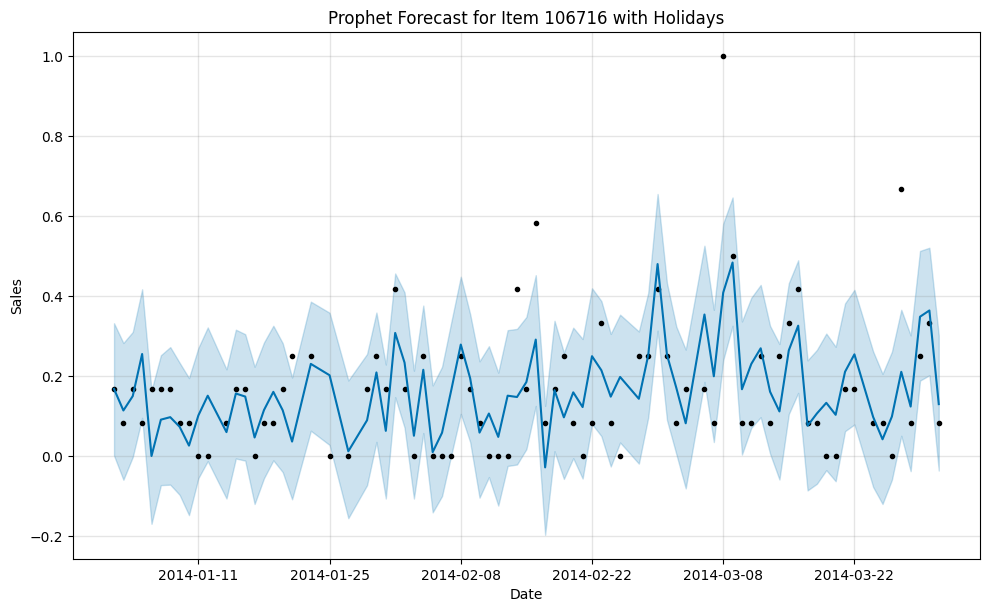

<Figure size 1400x700 with 0 Axes>

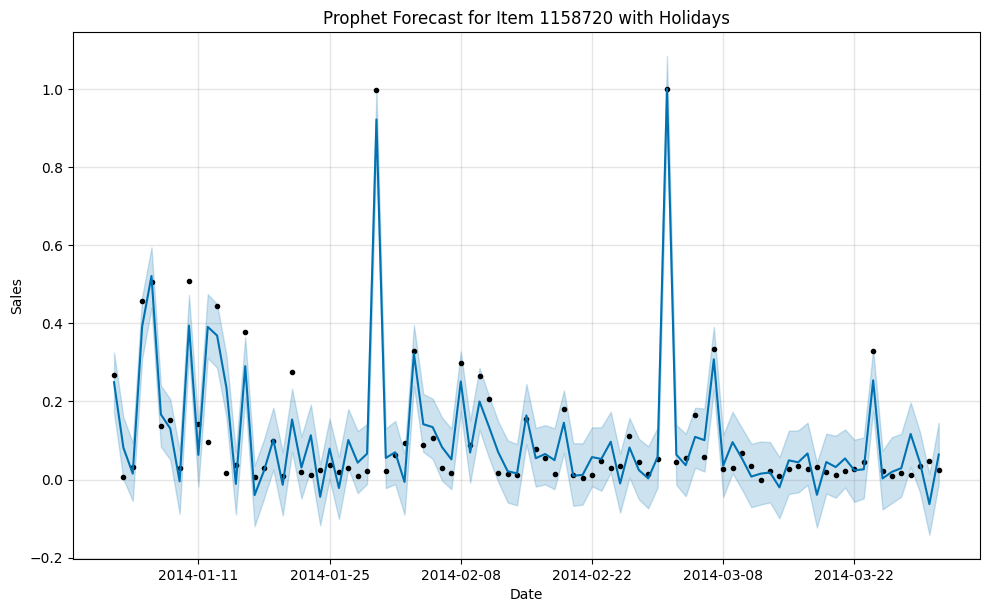

Visualization completed for all items.


In [206]:
import matplotlib.pyplot as plt

# Function to visualize Prophet forecast
def plot_prophet_forecast(item, model, forecast):
    plt.figure(figsize=(14, 7))
    model.plot(forecast)
    plt.title(f'Prophet Forecast for Item {item} with Holidays')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

# Loop through each item to visualize
for item in unique_items:
    plot_prophet_forecast(item, prophet_models[item], forecasts[item])

print("Visualization completed for all items.")
